## **Embedding - Clustering** (**EC**) Community Detection Framework Experiments


**Embedding - Clustering** (**EC**) Community Detection Framework is an extension of popular community detection algorithms - **Louvain** and **Leiden**. **EC** improves the results by creating a stable initial partitioning using the embedded representation of nodes. It is a three-step method of modularity optimization: 

**Step 1:**  Find an embedding function $\mathcal{E} \colon V \to \mathbb{R}^s$ which embeds each node of graph $G$ into a $s$-dimensional vector $\mathcal{E}(v) = \{z_1, z_2, \ldots, z_s\}$, where $s \ll n$.

**Step 2:** Run the clustering algorithm on the obtained latent representation $\mathcal{E}$ to get partition $\mathbf{A}$. 

**Step 3:** Use $\mathbf{A}$ as an initializing partitioning for the **Louvain** or  **Leiden** algorithm. The outcome partition $\mathbf{P}$ is a final result of the **EC** framework, that maximizes the modularity.

This Jupyter notebook contains code use to generate plots and tables used in analysis of **EC** framework.


<a class="anchor" id="toc"></a>
### Table of Contents

1. [ABCD networks](#abcd)<br>
    A. [Datasets](#dt) <br>
    B. [Tables](#tbl) <br>
    C. [ANOVA tables](#anova) <br>
    D. [Plots](#plt) <br>
    E. [EC Framework results relative to graph properties](#props)<br>
2. [Facebook Datasets](#fb) <br>

Required packages:

```
- CSV v0.10.4
- DataFrames v1.3.2
- Formatting v0.4.2
- Graphs v1.6.0
- LaTeXStrings v1.3.0
- Latexify v0.15.14
- Plots v1.27.4
- PyCall v1.93.1
- StatsBase v0.33.13
- StatsPlots v0.14.33
```

In [55]:
using Plots, DataFrames, StatsBase, StatsPlots
pyplot();
using Base.Iterators: product
using LaTeXStrings, Latexify
using PyCall
using Formatting
using Graphs
using CSV

Auxilliary functions (read data with **EC** results):

In [2]:
#general
function read_data(algo, measure; res_dir = res_dir,
        colnames = [:graph,:embed,:dim,:embed_params,:clustering_algo,
                :clustering_params, :mean, :std])
    rough_data = []
    for file in readdir(res_dir)
        params = split(file,'_')
        filetype = Symbol(params[1])
        graphname = Symbol(replace(params[4], ".dat" =>""))
        (filetype != :results || params[2] != algo || params[3] != measure) && continue
        for line in split.(readlines(res_dir * file),";")
            embed = Symbol(line[1])
            dim = parse(Int, line[2])
            embed_params = line[3]
            clustering_algo = Symbol(line[4])
            clustering_params = line[5]
            values = parse.(Float64, line[8:end])
            μ = mean(values)
            σ = std(values)
            attrs = Any[embed,dim,embed_params,clustering_algo,
                        clustering_params, μ,σ]
            #line = vcat(graphname, attrs,values)
            line = vcat(graphname, attrs)
            push!(rough_data, line)
        end
    end
    DataFrame(Matrix(permutedims(reduce(hcat,rough_data))), colnames)  
end

read_data (generic function with 1 method)

In [3]:
#ABCD networks
function read_data(algo, measure, n, ξ,  β, γ, min_deg; res_dir = res_dir,
        colnames = vcat([:n,:ξ,:γ,:β,:min_deg,:embed,:dim,:embed_params,:clustering_algo,
                :clustering_params,:best_global,:best_local, :mean, :std], 
            [Symbol("iter_$(i)") for i = 1:no_iters]))
    rough_data = []
    for file in readdir(res_dir)
        params = split(file,'_')
        filetype = Symbol(params[1])            
        (filetype != :results || params[2] != algo || params[3] != measure) && continue
        n != parse(Int, params[4]) && continue 
        ξ != parse(Float64, params[5]) && continue
        γ != parse(Float64, params[6]) && continue
        β != parse(Float64, params[7]) && continue
        min_deg != parse(Int, params[8][1]) && continue
        params = Any[n,ξ,γ,β,min_deg] 
        for line in split.(readlines(res_dir * file),";")
            embed = Symbol(line[1])
            dim = parse(Int, line[2])
            embed_params = line[3]
            clustering_algo = Symbol(line[4])
            clustering_params = line[5]
            best_global = parse(Float64,line[7])
            best_global == Inf && continue 
            best_local = parse(Float64,line[11])
            values = parse.(Float64, line[13:end])
            μ = mean(values)
            σ = std(values)
            attrs = Any[embed,dim,embed_params,clustering_algo,
                        clustering_params,best_global,best_local,
                        μ,σ]
            line = vcat(params, attrs, values)
            push!(rough_data, line)
        end
    end
    DataFrame(Matrix(permutedims(reduce(hcat,rough_data))), colnames)       
end

read_data (generic function with 2 methods)

In [53]:
degree_correlation(g) = [sum(sum(degree(g,nei) for nei in neighbors(g,n))/length(neighbors(g,n))
    for n in findall(x-> x == deg,degree(g)))/sum(degree(g).==deg)
        for deg in sort(unique(degree(g))) if deg != 0]

function correlation_exponent(g)
    x = log.(filter(x  -> x != 0, sort(unique(degree(g)))))
    y = log.(degree_correlation(g))
    # Fit the regression
    ([ones(length(x)) x] \ y)[2]
end

correlation_exponent (generic function with 1 method)

<a class="anchor" id="abcd"></a>
## ABCD Networks

---- [Return to Table of Contents](#toc) ----

In [4]:
#data directiories:
res_dir = "ECCD/results/"
graphs_dir = "experiment/graphs/";

In [5]:
#Graph Parameters:
ns = 10^3
ξs = [0.15, 0.25, 0.35, 0.5, 0.75]
βs = [1.1, 1.5, 1.9]
γs = [2.1, 2.5, 2.9]
min_degs = [1,2,5]

#Experiment Parameters:
min_dim = 8
no_iters = 50
measures = ["modularity", "ami"];

<a class="anchor" id="dt"></a>
### Datasets

Read data with results for baseline algorithms (**Louvain**, **Leiden** and **EC**):

In [6]:
rough_data = Dict("louvain_modularity" => [],
                "louvain_ami" => [],
                "leiden_modularity" => [],
                "leiden_ami" => [],
                "ecg_modularity" => [],
                "ecg_ami" => [],);

In [7]:
for algo in ["louvain", "leiden", "ecg"]
    for measure in measures
        for file in readdir(res_dir)
            params = split(file,'_')
            filetype = Symbol(params[1])            
            (filetype != :g || params[3] != algo || params[4] != measure) && continue
            n = parse(Int, params[5])
            ξ = parse(Float64, params[6])
            γ = parse(Float64, params[7])
            β = parse(Float64, params[8])
            min_deg = parse(Int, params[9][1])
            values = parse.(Float64,split.(readlines(res_dir * file),";")[1])
            μ = mean(values)
            σ = std(values)
            line = vcat(Any[n,ξ,γ,β,min_deg,μ,σ], values)
            push!(rough_data["$(algo)_$(measure)"], line)
        end
    end
end

In [8]:
colnames = vcat([:n,:ξ,:γ,:β,:min_deg,:mean,:std], [Symbol("iter_$(i)") for i = 1:no_iters]);
baseline_dfs = Dict("louvain_modularity" => 
    DataFrame(Matrix(transpose(reduce(hcat,rough_data["louvain_modularity"]))), colnames),
                "louvain_ami" => 
   DataFrame(Matrix(transpose(reduce(hcat,rough_data["louvain_ami"]))), colnames),
                "leiden_modularity" => 
    DataFrame(Matrix(transpose(reduce(hcat,rough_data["leiden_modularity"]))), colnames),
                "leiden_ami" => 
    DataFrame(Matrix(transpose(reduce(hcat,rough_data["leiden_ami"]))), colnames),
                "ecg_modularity" => 
    DataFrame(Matrix(transpose(reduce(hcat,rough_data["ecg_modularity"]))), colnames),
                "ecg_ami" => 
    DataFrame(Matrix(transpose(reduce(hcat,rough_data["ecg_ami"]))), colnames),
    );

<a class="anchor" id="tbl"></a>
### Tables

---- [Return to Table of Contents](#toc) ----

#### Modularity in relation to $\xi$

Modularity increase with respect to baseline (plain **Louvain**) for **ABCD** graphs with different values of $\xi$ and fixed $\beta$, $\gamma$, and $\delta$. Column *Baseline Louvain* shows the average modularity index (modularity $\times$ 100) with standard deviation. Other columns present the modularity change relative to **Louvain** (in percentage). For **EC** methods, the best performing combination of embedding and clustering algorithms was chosen.

In [9]:
n = 1000
ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5
save_file = false;

In [10]:
#ξ:
table = DataFrame(parameters = Symbol[], Louvain = Tuple{Float64,Float64}[], 
                ECG = Tuple{Float64,Float64}[], Leiden = Tuple{Float64,Float64}[], 
                EC_Louvain = Tuple{Float64,Float64}[], EC_Leiden = Tuple{Float64,Float64}[])
for (ξ, β, γ, min_deg) in sort(reshape(collect(product(ξs,β,γ,min_deg)),:));
    param = Symbol(ξ)
    try
        mod = groupby(groupby(baseline_dfs["louvain_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1][!,:mean][1]
        lstd = groupby(groupby(baseline_dfs["louvain_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1][!,:std][1]
        louvain = round.((mod * 100,lstd * 100), digits = 2)
        
        ecg = groupby(groupby(baseline_dfs["ecg_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
        ecg_mod = (ecg[!,:mean][1] - mod) / mod * 100 
        ecg_std = ecg[!,:std][1] * 100
        ecg = round.((ecg_mod, ecg_std), digits = 2)
        
        leiden = groupby(groupby(baseline_dfs["leiden_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
        leiden_mod = (leiden[!,:mean][1] - mod)  / mod * 100 
        leiden_std = leiden[!,:std][1] * 100
        leiden = round.((leiden_mod, leiden_std), digits = 2)
        
        ec_louvain = read_data("louvain", "modularity", n, ξ, β, γ, min_deg)
        ec_louvain = ec_louvain[ec_louvain.mean .== maximum(ec_louvain.mean),:]
        ec_louvain_mod = (ec_louvain[!,:mean][1] - mod) / mod * 100 
        ec_louvain_std = ec_louvain[!,:std][1] * 100
        ec_louvain = round.((ec_louvain_mod, ec_louvain_std), digits = 2)
        
        ec_leiden = read_data("leiden", "modularity", n, ξ, β, γ, min_deg)
        ec_leiden = ec_leiden[ec_leiden.mean .== maximum(ec_leiden.mean),:]
        ec_leiden_mod = (ec_leiden[!,:mean][1] - mod) / mod * 100 
        ec_leiden_std = ec_leiden[!,:std][1] * 100
        ec_leiden = round.((ec_leiden_mod, ec_leiden_std), digits = 2)
        push!(table, vcat(param, louvain, ecg, leiden, ec_louvain, ec_leiden))
    catch
        push!(table, vcat(param, fill((0,0),5)))
    end
end
if save_file
    open("xi_table.tex", "w") do file
        write(file, latextabular(table, latex=false))
    end
end
table

5×6 DataFrame
 Row │ parameters  Louvain        ECG            Leiden        EC_Louvain    E ⋯
     │ Symbol      Tuple…         Tuple…         Tuple…        Tuple…        T ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.15        (0.0, 0.0)     (0.0, 0.0)     (0.0, 0.0)    (0.0, 0.0)    ( ⋯
   2 │ 0.25        (68.04, 0.05)  (-0.34, 0.01)  (0.05, 0.01)  (0.03, 0.03)  (
   3 │ 0.35        (58.13, 0.5)   (0.05, 0.02)   (0.5, 0.04)   (0.25, 0.24)  (
   4 │ 0.5         (45.26, 0.85)  (2.0, 0.12)    (3.52, 0.29)  (1.32, 0.7)   (
   5 │ 0.75        (30.53, 0.36)  (-6.51, 0.28)  (6.4, 0.29)   (3.2, 0.45)   ( ⋯
                                                                1 column omitted

#### Modularity in relation to $\delta$

Modularity increase with respect to baseline (plain **Louvain**) for **ABCD** graphs with different values of $delta$ and fixed $\xi$, $\beta$, and $\gamma$,. Column *Baseline Louvain* shows the average modularity index (modularity $\times$ 100) with standard deviation. Other columns present the modularity change relative to **Louvain** (in percentage). For **EC** methods, the best performing combination of embedding and clustering algorithms was chosen.

In [11]:
n = 1000
ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5
save_file = false;

In [12]:
#δ:
table = DataFrame(parameters = Symbol[], Louvain = Tuple{Float64,Float64}[], 
                ECG = Tuple{Float64,Float64}[], Leiden = Tuple{Float64,Float64}[], 
                EC_Louvain = Tuple{Float64,Float64}[], EC_Leiden = Tuple{Float64,Float64}[])
for (ξ, β, γ, min_deg) in sort(reshape(collect(product(ξ,β,γ,min_degs)),:));
    param = Symbol(min_deg)
    try
        mod = groupby(groupby(baseline_dfs["louvain_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1][!,:mean][1]
        lstd = groupby(groupby(baseline_dfs["louvain_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1][!,:std][1]
        louvain = round.((mod * 100,lstd * 100), digits = 2)
        
        ecg = groupby(groupby(baseline_dfs["ecg_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
        ecg_mod = (ecg[!,:mean][1] - mod )/ mod * 100 
        ecg_std = ecg[!,:std][1] * 100
        ecg = round.((ecg_mod, ecg_std), digits = 2)
        
        leiden = groupby(groupby(baseline_dfs["leiden_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
        leiden_mod = (leiden[!,:mean][1] - mod )/ mod * 100 
        leiden_std = leiden[!,:std][1] * 100
        leiden = round.((leiden_mod, leiden_std), digits = 2)
        
        ec_louvain = read_data("louvain", "modularity", n, ξ, β, γ, min_deg)
        ec_louvain = ec_louvain[ec_louvain.mean .== maximum(ec_louvain.mean),:]
        ec_louvain_mod = (ec_louvain[!,:mean][1] - mod)/ mod * 100 
        ec_louvain_std = ec_louvain[!,:std][1] * 100
        ec_louvain = round.((ec_louvain_mod, ec_louvain_std), digits = 2)
        
        ec_leiden = read_data("leiden", "modularity", n, ξ, β, γ, min_deg)
        ec_leiden = ec_leiden[ec_leiden.mean .== maximum(ec_leiden.mean),:]
        ec_leiden_mod = (ec_leiden[!,:mean][1] - mod)/ mod * 100 
        ec_leiden_std = ec_leiden[!,:std][1] * 100
        ec_leiden = round.((ec_leiden_mod, ec_leiden_std), digits = 2)
        push!(table, vcat(param, louvain, ecg, leiden, ec_louvain, ec_leiden))
    catch
        push!(table, vcat(param, fill((0,0),5)))
    end
end
if save_file
    open("min_deg_table.tex", "w") do file
                write(file, latextabular(table, latex=false))
    end
end
table

3×6 DataFrame
 Row │ parameters  Louvain        ECG            Leiden        EC_Louvain    E ⋯
     │ Symbol      Tuple…         Tuple…         Tuple…        Tuple…        T ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1           (91.5, 0.09)   (-0.79, 0.09)  (0.13, 0.08)  (0.01, 0.1)   ( ⋯
   2 │ 2           (56.47, 0.26)  (-8.96, 0.23)  (1.81, 0.29)  (0.19, 0.22)  (
   3 │ 5           (45.26, 0.85)  (2.0, 0.12)    (3.52, 0.29)  (1.32, 0.7)   (
                                                                1 column omitted

#### Modularity in relation to $\beta$

Modularity increase with respect to baseline (plain **Louvain**) for **ABCD** graphs with different values of $\xi$ and fixed $\xi$, $\gamma$, and $\delta$. Column *Baseline Louvain* shows the average modularity index (modularity $\times$ 100) with standard deviation. Other columns present the modularity change relative to **Louvain** (in percentage). For **EC** methods, the best performing combination of embedding and clustering algorithms was chosen.

In [13]:
n = 1000
ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5
save_file = false;

In [14]:
#β:
table = DataFrame(parameters = Symbol[], Louvain = Tuple{Float64,Float64}[], 
                ECG = Tuple{Float64,Float64}[], Leiden = Tuple{Float64,Float64}[], 
                EC_Louvain = Tuple{Float64,Float64}[], EC_Leiden = Tuple{Float64,Float64}[])
for (ξ, β, γ, min_deg) in sort(reshape(collect(product(ξ,βs,γ,min_deg)),:));
    param = Symbol(β)
    try
        mod = groupby(groupby(baseline_dfs["louvain_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1][!,:mean][1]
        lstd = groupby(groupby(baseline_dfs["louvain_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1][!,:std][1]
        louvain = round.((mod * 100,lstd * 100), digits = 2)
        
        ecg = groupby(groupby(baseline_dfs["ecg_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
        ecg_mod = (ecg[!,:mean][1] - mod )/ mod * 100 
        ecg_std = ecg[!,:std][1] * 100
        ecg = round.((ecg_mod, ecg_std), digits = 2)
        
        leiden = groupby(groupby(baseline_dfs["leiden_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
        leiden_mod = (leiden[!,:mean][1] - mod )/ mod * 100 
        leiden_std = leiden[!,:std][1] * 100
        leiden = round.((leiden_mod, leiden_std), digits = 2)
        
        ec_louvain = read_data("louvain", "modularity", n, ξ, β, γ, min_deg)
        ec_louvain = ec_louvain[ec_louvain.mean .== maximum(ec_louvain.mean),:]
        ec_louvain_mod = (ec_louvain[!,:mean][1] - mod)/ mod * 100 
        ec_louvain_std = ec_louvain[!,:std][1] * 100
        ec_louvain = round.((ec_louvain_mod, ec_louvain_std), digits = 2)
        
        ec_leiden = read_data("leiden", "modularity", n, ξ, β, γ, min_deg)
        ec_leiden = ec_leiden[ec_leiden.mean .== maximum(ec_leiden.mean),:]
        ec_leiden_mod = (ec_leiden[!,:mean][1] - mod)/ mod * 100 
        ec_leiden_std = ec_leiden[!,:std][1] * 100
        ec_leiden = round.((ec_leiden_mod, ec_leiden_std), digits = 2)
        push!(table, vcat(param, louvain, ecg, leiden, ec_louvain, ec_leiden))
    catch
        push!(table, vcat(param, fill((0,0),5)))
    end
end
if save_file
    open("beta_table.tex", "w") do file
                write(file, latextabular(table, latex=false))
    end
end
table

3×6 DataFrame
 Row │ parameters  Louvain        ECG           Leiden        EC_Louvain    EC ⋯
     │ Symbol      Tuple…         Tuple…        Tuple…        Tuple…        Tu ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1.1         (41.13, 1.16)  (5.29, 0.42)  (7.06, 1.19)  (2.05, 1.11)  (1 ⋯
   2 │ 1.5         (45.26, 0.85)  (2.0, 0.12)   (3.52, 0.29)  (1.32, 0.7)   (4
   3 │ 1.9         (43.22, 0.97)  (2.12, 0.21)  (3.22, 0.54)  (1.2, 0.89)   (4
                                                                1 column omitted

#### Modularity in relation to $\gamma$

Modularity increase with respect to baseline (plain **Louvain**) for **ABCD** graphs with different values of $\xi$ and fixed $\xi$, $\beta$, and $\delta$. Column *Baseline Louvain* shows the average modularity index (modularity $\times$ 100) with standard deviation. Other columns present the modularity change relative to **Louvain** (in percentage). For **EC** methods, the best performing combination of embedding and clustering algorithms was chosen.

In [15]:
n = 1000
ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5
save_file = false;

In [16]:
#β:
table = DataFrame(parameters = Symbol[], Louvain = Tuple{Float64,Float64}[], 
                ECG = Tuple{Float64,Float64}[], Leiden = Tuple{Float64,Float64}[], 
                EC_Louvain = Tuple{Float64,Float64}[], EC_Leiden = Tuple{Float64,Float64}[])
for (ξ, β, γ, min_deg) in sort(reshape(collect(product(ξ,β,γs,min_deg)),:));
    param = Symbol(γ)
    try
        mod = groupby(groupby(baseline_dfs["louvain_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1][!,:mean][1]
        lstd = groupby(groupby(baseline_dfs["louvain_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1][!,:std][1]
        louvain = round.((mod * 100,lstd * 100), digits = 2)
        
        ecg = groupby(groupby(baseline_dfs["ecg_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
        ecg_mod = (ecg[!,:mean][1] - mod )/ mod * 100 
        ecg_std = ecg[!,:std][1] * 100
        ecg = round.((ecg_mod, ecg_std), digits = 2)
        
        leiden = groupby(groupby(baseline_dfs["leiden_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
        leiden_mod = (leiden[!,:mean][1] - mod)/ mod * 100  
        leiden_std = leiden[!,:std][1] * 100
        leiden = round.((leiden_mod, leiden_std), digits = 2)
        
        ec_louvain = read_data("louvain", "modularity", n, ξ, β, γ, min_deg)
        ec_louvain = ec_louvain[ec_louvain.mean .== maximum(ec_louvain.mean),:]
        ec_louvain_mod = (ec_louvain[!,:mean][1] - mod)/ mod * 100 
        ec_louvain_std = ec_louvain[!,:std][1] * 100
        ec_louvain = round.((ec_louvain_mod, ec_louvain_std), digits = 2)
        
        ec_leiden = read_data("leiden", "modularity", n, ξ, β, γ, min_deg)
        ec_leiden = ec_leiden[ec_leiden.mean .== maximum(ec_leiden.mean),:]
        ec_leiden_mod = (ec_leiden[!,:mean][1] - mod)/ mod * 100 
        ec_leiden_std = ec_leiden[!,:std][1] * 100
        ec_leiden = round.((ec_leiden_mod, ec_leiden_std), digits = 2)
        push!(table, vcat(param, louvain, ecg, leiden, ec_louvain, ec_leiden))
    catch
        push!(table, vcat(param, fill((0,0),5)))
    end
end
if save_file
    open("gamma_table.tex", "w") do file
                write(file, latextabular(table, latex=false))
    end
end
table

3×6 DataFrame
 Row │ parameters  Louvain        ECG           Leiden        EC_Louvain    EC ⋯
     │ Symbol      Tuple…         Tuple…        Tuple…        Tuple…        Tu ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2.1         (44.87, 1.05)  (2.13, 0.14)  (2.93, 0.31)  (1.0, 0.77)   (3 ⋯
   2 │ 2.5         (45.26, 0.85)  (2.0, 0.12)   (3.52, 0.29)  (1.32, 0.7)   (4
   3 │ 2.9         (41.77, 0.73)  (1.95, 0.46)  (5.88, 0.66)  (0.84, 1.09)  (9
                                                                1 column omitted

#### AMI in relation to $\xi$

Adjusted Mutual Information (**AMI**) increase with respect to baseline (plain **Louvain**) for **ABCD** graphs with different values of $\xi$ and fixed $\beta$, $\gamma$, and $\delta$. Column *Baseline Louvain* shows the average AMI index (AMI $\times$ 100) with standard deviation. Other columns present the AMI change relative to **Louvain** (in percentage). For **EC** methods, the best-performing combination of embedding and clustering algorithms was chosen.

In [17]:
n = 1000
ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5
save_file

false

In [18]:
#ξ:
table = DataFrame(parameters = Symbol[], Louvain = Tuple{Float64,Float64}[], 
                ECG = Tuple{Float64,Float64}[], Leiden = Tuple{Float64,Float64}[], 
                EC_Louvain = Tuple{Float64,Float64}[], EC_Leiden = Tuple{Float64,Float64}[])
for (ξ, β, γ, min_deg) in sort(reshape(collect(product(ξs,β,γ,min_deg)),:));
    param = Symbol(ξ)
    try
        mod = groupby(groupby(baseline_dfs["louvain_ami"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1][!,:mean][1]
        lstd = groupby(groupby(baseline_dfs["louvain_ami"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1][!,:std][1]
        louvain = round.((mod * 100,lstd * 100), digits = 2)
        
        ecg = groupby(groupby(baseline_dfs["ecg_ami"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
        ecg_mod = (ecg[!,:mean][1] - mod) / mod * 100 
        #ecg_mod = ecg[!,:mean][1] 
        ecg_std = ecg[!,:std][1] * 100
        ecg = round.((ecg_mod, ecg_std), digits = 2)
        
        leiden = groupby(groupby(baseline_dfs["leiden_ami"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
        leiden_mod = (leiden[!,:mean][1] - mod)  / mod * 100 
        #leiden_mod = leiden[!,:mean][1]
        leiden_std = leiden[!,:std][1] * 100
        leiden = round.((leiden_mod, leiden_std), digits = 2)
        
        ec_louvain = read_data("louvain", "ami", n, ξ, β, γ, min_deg)
        ec_louvain = ec_louvain[ec_louvain.mean .== maximum(ec_louvain.mean),:]
        ec_louvain_mod = (ec_louvain[!,:mean][1] - mod) / mod * 100 
        #ec_louvain_mod = ec_louvain[!,:mean][1]
        ec_louvain_std = ec_louvain[!,:std][1] * 100
        ec_louvain = round.((ec_louvain_mod, ec_louvain_std), digits = 2)
        
        ec_leiden = read_data("leiden", "ami", n, ξ, β, γ, min_deg)
        ec_leiden = ec_leiden[ec_leiden.mean .== maximum(ec_leiden.mean),:]
        ec_leiden_mod = (ec_leiden[!,:mean][1] - mod) / mod * 100 
        #ec_leiden_mod = ec_leiden[!,:mean][1]
        ec_leiden_std = ec_leiden[!,:std][1] * 100
        ec_leiden = round.((ec_leiden_mod, ec_leiden_std), digits = 2)
        push!(table, vcat(param, louvain, ecg, leiden, ec_louvain, ec_leiden))
   catch
        push!(table, vcat(param, fill((0,0),5)))
    end
end
if save_file
    open("xi_table_ami.tex", "w") do file
                write(file, latextabular(table, latex=false))
    end
end
table

5×6 DataFrame
 Row │ parameters  Louvain        ECG            Leiden        EC_Louvain    E ⋯
     │ Symbol      Tuple…         Tuple…         Tuple…        Tuple…        T ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.15        (0.0, 0.0)     (0.0, 0.0)     (0.0, 0.0)    (0.0, 0.0)    ( ⋯
   2 │ 0.25        (95.13, 0.48)  (4.87, 0.05)   (0.4, 0.26)   (0.16, 0.4)   (
   3 │ 0.35        (95.24, 1.26)  (4.99, 0.04)   (0.99, 0.21)  (0.25, 0.83)  (
   4 │ 0.5         (79.86, 4.09)  (17.29, 0.67)  (9.84, 1.98)  (3.97, 3.62)  (
   5 │ 0.75        (12.5, 0.93)   (41.53, 0.84)  (1.06, 0.96)  (5.75, 0.88)  ( ⋯
                                                                1 column omitted

<a class="anchor" id="anova"></a>
### ANOVA Tables

---- [Return to Table of Contents](#toc) ----

Tables generated below are used to test the statistical significance of each embedding and clustering combination in both, **EC-Louvain** and **EC-Leiden** methods. ANOVA and Tukey's range tests from the [bioinfokit](https://github.com/reneshbedre/bioinfokit/tree/master) package were used. 

In [19]:
stats = pyimport("scipy.stats")  
pd = pyimport("pandas")  
biostat = pyimport("bioinfokit.analys")

PyObject <module 'bioinfokit.analys' from 'C:\\Users\\barto\\anaconda3\\Lib\\site-packages\\bioinfokit\\analys.py'>

In [20]:
function get_ANOVA(algo,n,ξ,β,γ)
    lvls = vcat(algo, string.([:LLE,:LE,:deepWalk, :node2vec, :LINE, :SDNE, :GraRep, :HOPE]))
    baseline = Array(groupby(groupby(baseline_dfs["$(algo)_modularity"],
            [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1][:,8:end])'
    df = pd.DataFrame(baseline, columns = [algo,]);
    for embed in [:LLE,:LE,:deepWalk, :node2vec, :LINE, :SDNE, :GraRep, :HOPE] 
        gdata = groupby(read_data(algo, "modularity", n, ξ, β, γ, min_deg), :embed)[(embed,)]
        best_algo = Array(gdata[gdata.mean .== maximum(gdata.mean),:][1,15:end])
        df.insert(df.shape[2], string(embed), best_algo )
    end
    df_melt = pd.melt(df.reset_index(), id_vars=["index"],  value_vars= lvls);
    df_melt.columns = ["index", "algos", "value"];

    res = biostat.stat()
    res.anova_stat(df=df_melt, res_var="value", anova_model="value ~ C(algos)")
    F, pval = res.anova_summary["F"][1], res.anova_summary["PR(>F)"][1]
end

get_ANOVA (generic function with 1 method)

In [21]:
function get_tukey(algo,n,ξ,β,γ)
    lvls = vcat(algo, string.([:LLE,:LE,:deepWalk, :node2vec, :LINE, :SDNE, :GraRep, :HOPE]))
    baseline = Array(groupby(groupby(baseline_dfs["$(algo)_modularity"],
            [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1][:,8:end])'
    df = pd.DataFrame(baseline, columns = [algo,]);
    for embed in [:LLE,:LE,:deepWalk, :node2vec, :LINE, :SDNE, :GraRep, :HOPE] 
        gdata = groupby(read_data(algo, "modularity", n, ξ, β, γ, min_deg), :embed)[(embed,)]
        best_algo = Array(gdata[gdata.mean .== maximum(gdata.mean),:][1,15:end])
        df.insert(df.shape[2], string(embed), best_algo )
    end
    df_melt = pd.melt(df.reset_index(), id_vars=["index"],  value_vars= lvls);
    df_melt.columns = ["index", "algos", "value"];
    print(df_melt)
    res = biostat.stat()
    res.tukey_hsd(df=df_melt, res_var="value", xfac_var="algos", anova_model="value ~ C(algos)")
    df_tukey = pd_to_df(res.tukey_summary)
    df_tukey[!,:group1] = replace.(pystring.(df_tukey[!,:group1]), "'" => "")
    df_tukey[!,:group2] = replace.(pystring.(df_tukey[!,:group2]), "'" => "")
    pd_to_df(df), df_tukey
    #table = DataFrame()
    #table[!,""] = lvls
    #for lvl in lvls
    #    pvalues = df[df[!,:group2] .== lvl,:][!,Symbol("p-value")]
    #    col = vcat(pvalues, zeros(length(lvls) - length(pvalues)))
    #    table[!,lvl] = col
    #end
    #table
end

get_tukey (generic function with 1 method)

In [22]:
function pd_to_df(df_pd)
    colnames = map(Symbol, df_pd.columns)
    df = DataFrame(Any[Array(df_pd[c].values) for c in colnames], colnames)
end

pd_to_df (generic function with 1 method)

In [23]:
extract_pval(table,algo1,algo2) = 
table[(table[!,"group1"].== algo1 .|| table[!,"group2"].== algo1) .& 
    (table[!,"group1"].== algo2 .|| table[!,"group2"].== algo2),:][!,"p-value"][1]

extract_pval (generic function with 1 method)

Modularity increase with respect to baseline (plain **Louvain**) for **ABCD** graphs with various combinations of parameters $\xi$, $\beta$, $\gamma$ and $\delta = 5$. Column *Baseline Louvain* shows the average modularity obtained by this algorithm. Other columns present the modularity change for **EC-Louvain** method for all tested embeddings. For each embedding, clustering algorithm that maximizes modularity was selected. Tukey's range test was used to compare **EC** methods, then one-way ANOVA was used to compare the best performing **EC-Louvain** combination with baseline.

In [ ]:
n = 1000
ξs = [0.25, 0.35, 0.5, 0.65, 0.75, 0.85]
βs = [1.1, 1.5, 1.9]
γs = [2.1, 2.5, 2.9]
min_deg = 5;
algo = "louvain"
save_file = false;

In [ ]:
table = DataFrame(ξ = Float64[], β = Float64[],γ = Float64[],
                Modularity = String[], LLE = String[],
                LE = String[], deepWalk = String[],
                node2vec = String[], LINE = String[],  
                SDNE = String[], GraRep = String[],
                HOPE = String[])
for (ξ, β, γ, min_deg) in sort(reshape(collect(product(ξs,βs,γs,min_deg)),:));
    res = Union{Float64,String}[ξ, β, γ]
    #try
        baseline = groupby(groupby(baseline_dfs["$(algo)_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
        mod = baseline[!,:mean][1] 
        std_dev = std(Array(baseline[:,8:end]))
        fvalue, pvalue = get_ANOVA(algo,n,ξ,β,γ)
    println(pvalue)
        starr =  pvalue < 0.1 ? (pvalue < 0.05 ? (pvalue < 0.01 ? 
                "\$\\sym{\\star\\star\\star}\$" : "\$\\sym{\\star\\star}\$") : "\$\\sym{\\star}\$") : ""
        push!(res, "\\textbf{$(round(mod, digits = 6))}$(starr)")
        df, df_tukey = get_tukey(algo,n,ξ,β,γ)
        df_summary = describe(df)
        df_summary = df_summary[df_summary[!,:variable] .!= Symbol(algo),:]
        best_mod, second_best_mod = sort(unique(df_summary[!,:mean]), rev = true)[1:2]
        best_embed = df_summary[df_summary[!,:mean] .== maximum(df_summary[!,:mean]), :][!,:variable][1]
        for embed in [:LLE,:LE,:deepWalk, :node2vec, :LINE, :SDNE, :GraRep, :HOPE]
            meanval = df_summary[df_summary[!,:variable] .== embed, :][!, :mean][1]
            pval_baseline = extract_pval(df_tukey,string(algo),string(embed))
            asterisk =  pval_baseline < 0.1 ? (pval_baseline < 0.05 ? (pval_baseline < 0.01 ? 
                "\\sym{***}" : "\\sym{**}") : "\\sym{*}") : ""
            pval_bestembed = extract_pval(df_tukey,string(embed), string(best_embed))
            plussym = embed != best_embed ? (pval_bestembed < 0.1 ? 
            (pval_bestembed < 0.05 ? (pval_bestembed < 0.01 ? 
                   "\\sym{+++}" : "\\sym{++}" ) : "\\sym{+}") : "") : ""
            if meanval == best_mod
                finalval = "\\textcolor{ForestGreen}{$(format(round(meanval - mod, digits = 6)))}"
            elseif meanval == second_best_mod
                finalval = "\\textcolor{blue}{$(format(round(meanval - mod, digits = 6)))}"
            else
                finalval = "$(format(round(meanval - mod, digits = 6)))"
            end
            push!(res, "$(finalval)$(asterisk)$(plussym)")
        end
        push!(table, res)
    #catch
    #    push!(table, vcat(res, fill((0,0),9)))
    #end
end
if save_file
    open("$(algo)_res_table.tex", "w") do file
            write(file, latextabular(table, latex=false))
    end
end

Modularity increase with respect to baseline (plain **Leiden**) for **ABCD** graphs with various combinations of parameters $\xi$, $\beta$, $\gamma$ and $\delta = 5$. Column *Baseline Louvain* shows the average modularity obtained by this algorithm. Other columns present the modularity change for **EC-Leiden** method for all tested embeddings. For each embedding, clustering algorithm that maximizes modularity was selected. Tukey's range test was used to compare **EC** methods, then one-way ANOVA was used to compare the best performing **EC-Leiden** combination with baseline.

In [ ]:
n = 1000
ξs = [0.25, 0.35, 0.5, 0.65, 0.75, 0.85]
βs = [1.1, 1.5, 1.9]
γs = [2.1, 2.5, 2.9]
min_deg = 5;
algo = "leiden"
save_file = false;

In [ ]:
table = DataFrame(ξ = Float64[], β = Float64[],γ = Float64[],
                Modularity = String[], LLE = String[],
                LE = String[], deepWalk = String[],
                node2vec = String[], LINE = String[],  
                SDNE = String[], GraRep = String[],
                HOPE = String[])
for (ξ, β, γ, min_deg) in sort(reshape(collect(product(ξs,βs,γs,min_deg)),:));
    res = Union{Float64,String}[ξ, β, γ]
    #try
        baseline = groupby(groupby(baseline_dfs["$(algo)_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
        mod = baseline[!,:mean][1] 
        std_dev = std(Array(baseline[:,8:end]))
        fvalue, pvalue = get_ANOVA(algo,n,ξ,β,γ)
    println(pvalue)
        starr =  pvalue < 0.1 ? (pvalue < 0.05 ? (pvalue < 0.01 ? 
                "\$\\sym{\\star\\star\\star}\$" : "\$\\sym{\\star\\star}\$") : "\$\\sym{\\star}\$") : ""
        push!(res, "\\textbf{$(round(mod, digits = 6))}$(starr)")
        df, df_tukey = get_tukey(algo,n,ξ,β,γ)
        df_summary = describe(df)
        df_summary = df_summary[df_summary[!,:variable] .!= Symbol(algo),:]
        best_mod, second_best_mod = sort(unique(df_summary[!,:mean]), rev = true)[1:2]
        best_embed = df_summary[df_summary[!,:mean] .== maximum(df_summary[!,:mean]), :][!,:variable][1]
        for embed in [:LLE,:LE,:deepWalk, :node2vec, :LINE, :SDNE, :GraRep, :HOPE]
            meanval = df_summary[df_summary[!,:variable] .== embed, :][!, :mean][1]
            pval_baseline = extract_pval(df_tukey,string(algo),string(embed))
            asterisk =  pval_baseline < 0.1 ? (pval_baseline < 0.05 ? (pval_baseline < 0.01 ? 
                "\\sym{***}" : "\\sym{**}") : "\\sym{*}") : ""
            pval_bestembed = extract_pval(df_tukey,string(embed), string(best_embed))
            plussym = embed != best_embed ? (pval_bestembed < 0.1 ? 
            (pval_bestembed < 0.05 ? (pval_bestembed < 0.01 ? 
                   "\\sym{+++}" : "\\sym{++}" ) : "\\sym{+}") : "") : ""
            if meanval == best_mod
                finalval = "\\textcolor{ForestGreen}{$(format(round(meanval - mod, digits = 6)))}"
            elseif meanval == second_best_mod
                finalval = "\\textcolor{blue}{$(format(round(meanval - mod, digits = 6)))}"
            else
                finalval = "$(format(round(meanval - mod, digits = 6)))"
            end
            push!(res, "$(finalval)$(asterisk)$(plussym)")
        end
        push!(table, res)
    #catch
    #    push!(table, vcat(res, fill((0,0),9)))
    #end
end
if save_file
    open("$(algo)_res_table.tex", "w") do file
            write(file, latextabular(table, latex=false))
    end
end

Modularity increase with respect to baseline (plain **Louvain**) for **ABCD** graphs with various combinations of parameters $\xi$, $\beta$, $\gamma$ and $\delta = 5$. Column *Baseline Louvain* shows the average modularity obtained by this algorithm. Other columns present the modularity change for **EC-Louvain** method for The best embedding and various clustering algorithms. Tukey's range test was used to compare **EC** methods, then one-way ANOVA was used to compare the best performing **EC-Louvain** combination with baseline.

In [ ]:
n = 1000
ξs = [0.25, 0.35, 0.5, 0.65, 0.75, 0.85]
βs = [1.1, 1.5, 1.9]
#βs = 1.5
γs = [2.1, 2.5, 2.9]
#γs = 2.5
min_deg = 5;
embeds = [:LLE,:LE,:deepWalk, :node2vec, :LINE, :SDNE, :GraRep, :HOPE]
algo = "louvain"
save_file = false;

In [ ]:
table = DataFrame(ξ = String[], β = String[],γ = String[], Modularity = String[],
                Embedding = String[], K_Means = String[],
                GMM = String[], HDBSCAN = String[])
for (ξ, β, γ, min_deg) in sort(reshape(collect(product(ξs,βs,γs,min_deg)),:));
    baseline = groupby(groupby(baseline_dfs["$(algo)_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
    mod = baseline[!,:mean][1] 
    firstline = string.([ξ, β, γ])
    push!(firstline,("\\textbf{$(round(mod, digits = 6))}"))
    secondline = ["","","","",""]
    g = read_data(algo, "modularity", n, ξ, β, γ, min_deg)
    best_algo = g[g.mean .== maximum(g.mean),:]
    simply_the_best = best_algo[!,:clustering_algo][1]
    best_embed = Array(best_algo[!,:embed])[1]
    dfs = []
    clusts = Dict()
    gdata = groupby(groupby(read_data(algo, "modularity", n, ξ, β, γ, min_deg), :embed)[(best_embed,)], :clustering_algo)
    for g in gdata
        best_algo = g[g.mean .== maximum(g.mean),:]
        best_mod = best_algo[!,:mean][1]
        best_clust = best_algo[!,:clustering_algo][1]
        best_params = best_algo[!,:clustering_params][1]
        best_algo = Array(best_algo[1,15:end])
        clusts["$(best_clust) ($(best_params))"] = best_mod
        df = pd.DataFrame(string.(Array(g[!,:clustering_algo])[1:50]), columns = ["clustering_algo",])
        df.insert(df.shape[2],  "value", best_algo)
        push!(dfs, df)
    end
    df = pd.concat(dfs);
    res = biostat.stat()
    res.anova_stat(df=df, res_var="value", anova_model="value ~ C(clustering_algo)")
    F, pvalue = res.anova_summary["F"][1], res.anova_summary["PR(>F)"][1]
    starr =  pvalue < 0.1 ? (pvalue < 0.05 ? (pvalue < 0.01 ? 
                    "\$\\sym{\\star\\star\\star}\$" : "\$\\sym{\\star\\star}\$") : "\$\\sym{\\star}\$") : ""
    push!(firstline, "$(best_embed)$(starr)")
    res.tukey_hsd(df=df, res_var="value", xfac_var="clustering_algo", anova_model="value ~ C(clustering_algo)")
    df_tukey = pd_to_df(res.tukey_summary)
    df_tukey[!,:group1] = replace.(pystring.(df_tukey[!,:group1]), "'" => "")
    df_tukey[!,:group2] = replace.(pystring.(df_tukey[!,:group2]), "'" => "")
    for clust in [Symbol("K-Means"), :GMM, :HDBSCAN]
        k = filter(x -> occursin(string(clust), x) , collect(keys(clusts)))[1]
        modval = clusts[k]
        pval_bestclust = extract_pval(df_tukey,string(clust), string(simply_the_best))
        asterisk = clust != simply_the_best ? (pval_bestclust < 0.1 ? 
                (pval_bestclust < 0.05 ? (pval_bestclust < 0.01 ? 
                       "\\sym{***}" : "\\sym{**}" ) : "\\sym{*}") : "") : ""
        if clust == simply_the_best 
            push!(firstline, "\\textcolor{ForestGreen}{$k}")
            push!(secondline, "\\textcolor{ForestGreen}{$(format(round(modval - mod, digits = 6)))$(asterisk)}")
        else
            push!(firstline, k)
            push!(secondline, "$(format(round(modval - mod, digits = 6)))$(asterisk)")
        end
    end
    push!(table, firstline)
    push!(table, secondline)
end
if save_file
    open("$(algo)_clustering_table.tex", "w") do file
                write(file, latextabular(table, latex=false))
    end
end

Modularity increase with respect to baseline (plain **Leiden**) for **ABCD** graphs with various combinations of parameters $\xi$, $\beta$, $\gamma$ and $\delta = 5$. Column *Baseline Louvain* shows the average modularity obtained by this algorithm. Other columns present the modularity change for **EC-Leiden** method for The best embedding and various clustering algorithms. Tukey's range test was used to compare **EC** methods, then one-way ANOVA was used to compare the best performing **EC-Leiden** combination with baseline.

In [ ]:
n = 1000
ξs = [0.25, 0.35, 0.5, 0.65, 0.75, 0.85]
βs = [1.1, 1.5, 1.9]
#βs = 1.5
γs = [2.1, 2.5, 2.9]
#γs = 2.5
min_deg = 5;
embeds = [:LLE,:LE,:deepWalk, :node2vec, :LINE, :SDNE, :GraRep, :HOPE]
algo = "leiden"
save_file = false;

In [ ]:
table = DataFrame(ξ = String[], β = String[],γ = String[], Modularity = String[],
                Embedding = String[], K_Means = String[],
                GMM = String[], HDBSCAN = String[])
for (ξ, β, γ, min_deg) in sort(reshape(collect(product(ξs,βs,γs,min_deg)),:));
    baseline = groupby(groupby(baseline_dfs["$(algo)_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
    mod = baseline[!,:mean][1] 
    firstline = string.([ξ, β, γ])
    push!(firstline,("\\textbf{$(round(mod, digits = 6))}"))
    secondline = ["","","","",""]
    g = read_data(algo, "modularity", n, ξ, β, γ, min_deg)
    best_algo = g[g.mean .== maximum(g.mean),:]
    simply_the_best = best_algo[!,:clustering_algo][1]
    best_embed = Array(best_algo[!,:embed])[1]
    dfs = []
    clusts = Dict()
    gdata = groupby(groupby(read_data(algo, "modularity", n, ξ, β, γ, min_deg), :embed)[(best_embed,)], :clustering_algo)
    for g in gdata
        best_algo = g[g.mean .== maximum(g.mean),:]
        best_mod = best_algo[!,:mean][1]
        best_clust = best_algo[!,:clustering_algo][1]
        best_params = best_algo[!,:clustering_params][1]
        best_algo = Array(best_algo[1,15:end])
        clusts["$(best_clust) ($(best_params))"] = best_mod
        df = pd.DataFrame(string.(Array(g[!,:clustering_algo])[1:50]), columns = ["clustering_algo",])
        df.insert(df.shape[2],  "value", best_algo)
        push!(dfs, df)
    end
    df = pd.concat(dfs);
    res = biostat.stat()
    res.anova_stat(df=df, res_var="value", anova_model="value ~ C(clustering_algo)")
    F, pvalue = res.anova_summary["F"][1], res.anova_summary["PR(>F)"][1]
    starr =  pvalue < 0.1 ? (pvalue < 0.05 ? (pvalue < 0.01 ? 
                    "\$\\sym{\\star\\star\\star}\$" : "\$\\sym{\\star\\star}\$") : "\$\\sym{\\star}\$") : ""
    push!(firstline, "$(best_embed)$(starr)")
    res.tukey_hsd(df=df, res_var="value", xfac_var="clustering_algo", anova_model="value ~ C(clustering_algo)")
    df_tukey = pd_to_df(res.tukey_summary)
    df_tukey[!,:group1] = replace.(pystring.(df_tukey[!,:group1]), "'" => "")
    df_tukey[!,:group2] = replace.(pystring.(df_tukey[!,:group2]), "'" => "")
    for clust in [Symbol("K-Means"), :GMM, :HDBSCAN]
        k = filter(x -> occursin(string(clust), x) , collect(keys(clusts)))[1]
        modval = clusts[k]
        pval_bestclust = extract_pval(df_tukey,string(clust), string(simply_the_best))
        asterisk = clust != simply_the_best ? (pval_bestclust < 0.1 ? 
                (pval_bestclust < 0.05 ? (pval_bestclust < 0.01 ? 
                       "\\sym{***}" : "\\sym{**}" ) : "\\sym{*}") : "") : ""
        if clust == simply_the_best 
            push!(firstline, "\\textcolor{ForestGreen}{$k}")
            push!(secondline, "\\textcolor{ForestGreen}{$(format(round(modval - mod, digits = 6)))$(asterisk)}")
        else
            push!(firstline, k)
            push!(secondline, "$(format(round(modval - mod, digits = 6)))$(asterisk)")
        end
    end
    push!(table, firstline)
    push!(table, secondline)
end
if save_file
    open("$(algo)_clustering_table.tex", "w") do file
            write(file, latextabular(table, latex=false))
    end
end

<a class="anchor" id="plt"></a>
### Plots

Modularity (dashed line represents modularity of the baseline algorithm) and Global/Local CGE scores (the lower score, the better) for different embeddings in **ABCD** graph with parameters: $\xi$, $\beta$, $\gamma$, and $\delta$.

In [37]:
n = 1000
ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5;
embeds = [:LLE,:LE,:deepWalk, :node2vec, :LINE, :SDNE, :GraRep, :HOPE];
pyplot()

Plots.PyPlotBackend()

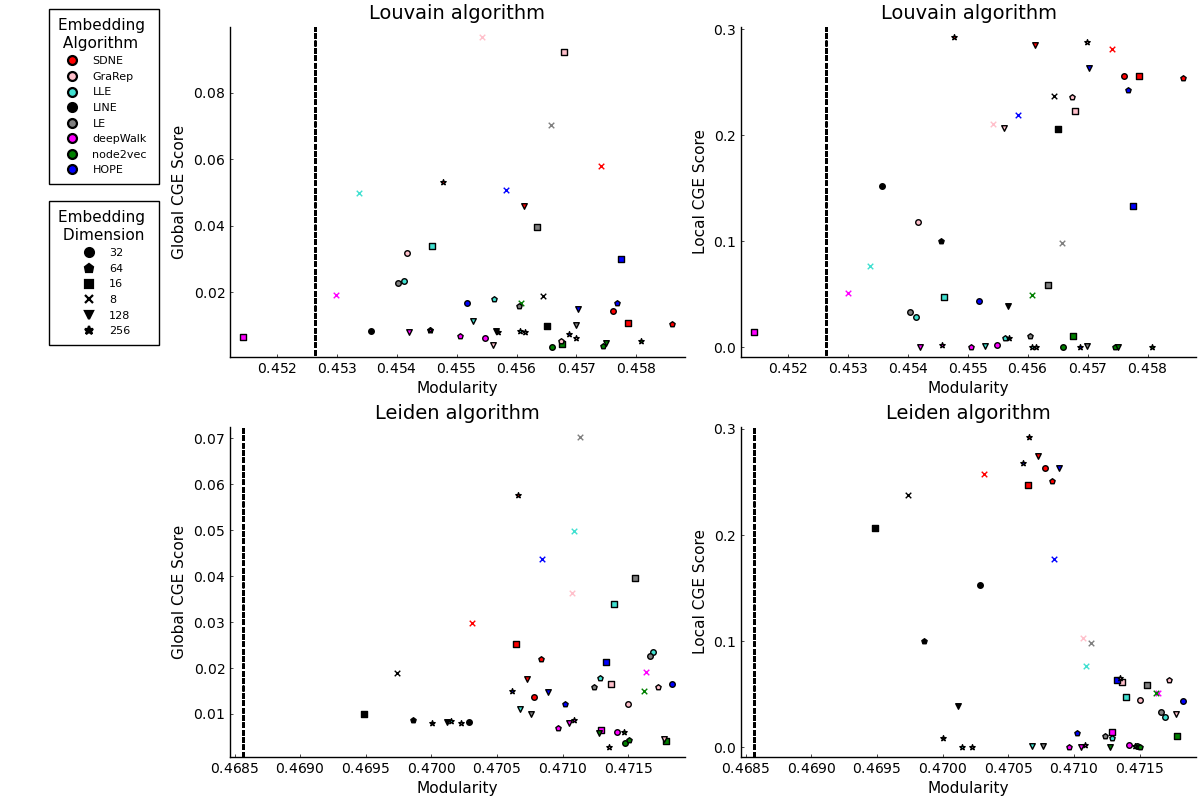

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [38]:
colors = Dict(:LE => :gray,
            :deepWalk => :magenta,
            :node2vec => :green,
            :LINE => :black,
            :SDNE => :red,
            :GraRep => :pink,
            :HOPE => :blue,
            :LLE => :turquoise)

markers = Dict(8 => :x,
            16 => :rect,
            32 => :circle,
            64 => :pentagon,
            128 => :dtriangle,
            256 => :star1)

l1 = @layout [a; b]
l2 = @layout [a{0.15w} b c]

p1 = plot(size = (128,250),  
legendtitle = "Embedding \n Algorithm", xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for (i, embed) in enumerate(keys(colors))
        scatter!(p1, rand(1,1), markercolor = colors[embed], label = String(embed))
end

p2 = plot(legendtitle = "Embedding \n Dimension",
    size = (128,250), xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for dim in collect(keys(markers))
        scatter!(p2, rand(1,1), markercolor = :black, markershape = markers[dim], label = "$(dim)")
end
    
p_leg = plot(p1,p2, size = (125,400), layout = l1)
p_empty = plot(size = (125,400), xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false); 
    
plts = []
for algo in ["louvain", "leiden"] 
    for (cge, key) in [("Global CGE Score", :best_global), ("Local CGE Score", :best_local)]
    
        p = scatter(legend= false, label = collect(keys(colors)))
        
            
        group = groupby(groupby(read_data(algo, "modularity", n, ξ, β, γ, min_deg),
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :dim)
        for gr in group
            group2 = groupby(gr, :embed)
            for  g in group2
                #group2 = groupby(g, [:embed_params])
                dim = unique(g[!,:dim])[1]
                embed = unique(g[!,:embed])[1]
                mods = []
                score = []
                best_algo = g[g.mean .== maximum(g.mean),:]
                push!(mods, best_algo[!,:mean][1])
                push!(score,best_algo[!,key][1])
                
                (markers[dim] == :circle) && algo == "louvain" ?  (label = "$embed") : 
                ((colors[embed] == :black) && algo == "leiden" ? (label = "$dim") : label = "") 
                
                scatter!(p, mods, score,
                markercolor = colors[embed], markershape = markers[dim], 
                xlabel = "Modularity", ylabel = String(cge),  xtickfontsize=10, ytickfontsize=10,
                grid = false, label = "", title = "L$(algo[2:end]) algorithm")
                line = groupby(groupby(baseline_dfs["$(algo)_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
                mod = line[!,:mean][1]
                vline!([mod,], label = "", linestyle = :dash, color = :black)
                
            end
            
        end
        push!(plts, p)
    end
end

    
plot(plot(p_leg,plts[1], plts[2], size = (1200,400), layout = l2),
plot(p_empty,plts[3], plts[4], size = (1200,400), layout = l2), 
size = (1200,800), layout = l1)
save_file && savefig("scores_dims.eps")

Modularity (dashed line represents modularity of the baseline algorithm) and AMI Index (dashed red line represents results for the baseline algorithm) for different embeddings in **ABCD** graph with parameters: $\xi$, $\beta =1.5$, $\gamma = 2.5$, and $\delta$.

In [33]:
n = 1000
ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5
save_file = false;

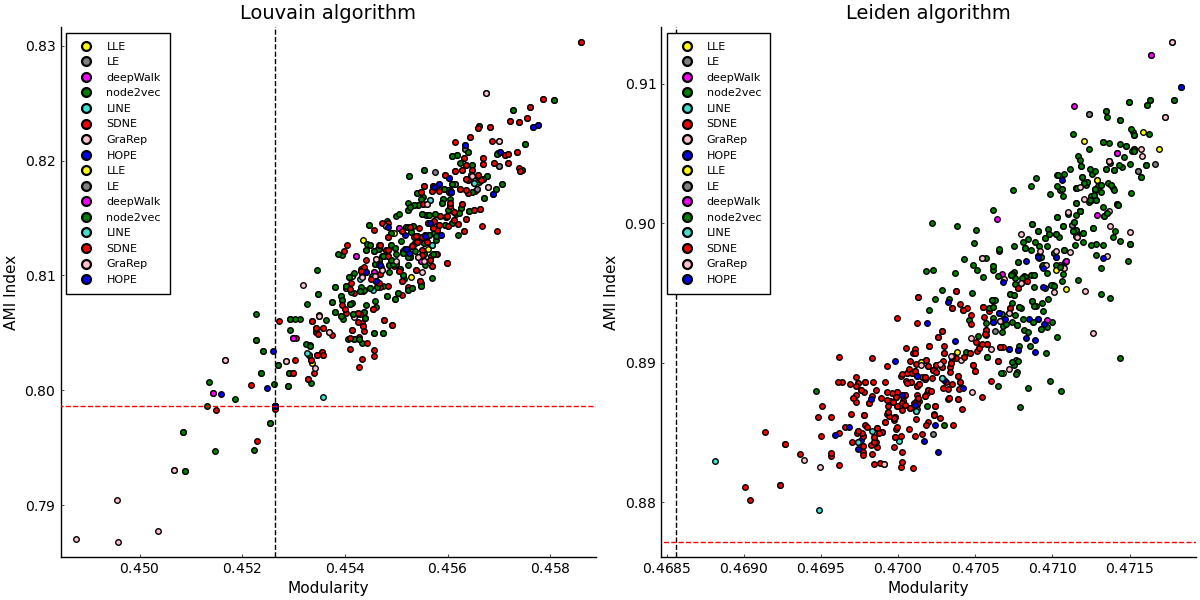

In [35]:
colors = Dict(:LE => :gray,
            :deepWalk => :magenta,
            :node2vec => :green,
            :LINE => :turquoise,
            :SDNE => :red,
            :GraRep => :pink,
            :HOPE => :blue,
            :LLE => :yellow)

plts = []
for algo in ["louvain", "leiden"] 
        p = scatter(legend= :topleft)
        modularity_data = read_data(algo, "modularity", n, ξ, β, γ, min_deg)
        ami_data = read_data(algo, "ami", n, ξ, β, γ, min_deg)
        group_modularity = groupby(modularity_data, :embed)
        group_ami = groupby(ami_data, :embed)
        for g in group_modularity
            label = unique(g[!,:embed])[1]
            group_modularity2 = groupby(g, [:dim, :embed_params])
            mods = []
            ami = []
            for g2 in group_modularity2
                best_algo = g2[g2.mean .== maximum(g2.mean),:][1,:]
                push!(mods, best_algo[:mean][1])
                rowmatch = findfirst(x->x==Tuple(best_algo[1:10]), Tuple.(eachrow(select(ami_data, Between(1,10)))))
                push!(ami,ami_data[rowmatch, :][:mean][1])
            end
            scatter!(p, mods, ami,
                markercolor = colors[label], markershape = :circle, 
                xlabel = "Modularity", ylabel = "AMI Index",  xtickfontsize=10, ytickfontsize=10,
                grid = false, label = String(label), title = "L$(algo[2:end]) algorithm")
        end
        for g in group_ami
            label = unique(g[!,:embed])[1]
            group_ami2 = groupby(g, [:dim, :embed_params])
            mods = []
            ami = []
            for g2 in group_ami2
                best_algo = g2[g2.mean .== maximum(g2.mean),:][1,:]
                push!(ami, best_algo[:mean][1])
                rowmatch = findfirst(x->x==Tuple(best_algo[1:10]), Tuple.(eachrow(select(modularity_data, Between(1,10)))))
                push!(mods,modularity_data[rowmatch, :][:mean][1])
            end
            scatter!(p, mods, ami,
                markercolor = colors[label], markershape = :circle, 
                xlabel = "Modularity", ylabel = "AMI Index",  xtickfontsize=10, ytickfontsize=10,
                grid = false, label = String(label), title = "L$(algo[2:end]) algorithm")
        end
        line = groupby(groupby(baseline_dfs["$(algo)_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
        mod = line[!,:mean][1]
        vline!([mod,], label = "", linestyle = :dash, color = :black)
        line = groupby(groupby(baseline_dfs["$(algo)_ami"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
        mod = line[!,:mean][1]
        hline!([mod,], label = "", linestyle = :dash, color = :red)
        push!(plts, p)
end
plot(plts..., layout = (1,2), size = (1200,600))
save_file && savefig("modularity_ami.eps")

**EC-Louvain** modularity for different clustering algorithms in **ABCD** graphs with different values of $\xi$ and fixed $\xi$, $\beta$, and $\delta$. For each $\xi$ and clustering algorithm embedding maximizing modularity was chosen.

In [43]:
n = 1000
ξs = [0.25, 0.35, 0.5, 0.65, 0.75, 0.85]
βs = 1.5
γs = 2.5
min_deg = 5;
algo = "louvain"
save_fig = false;

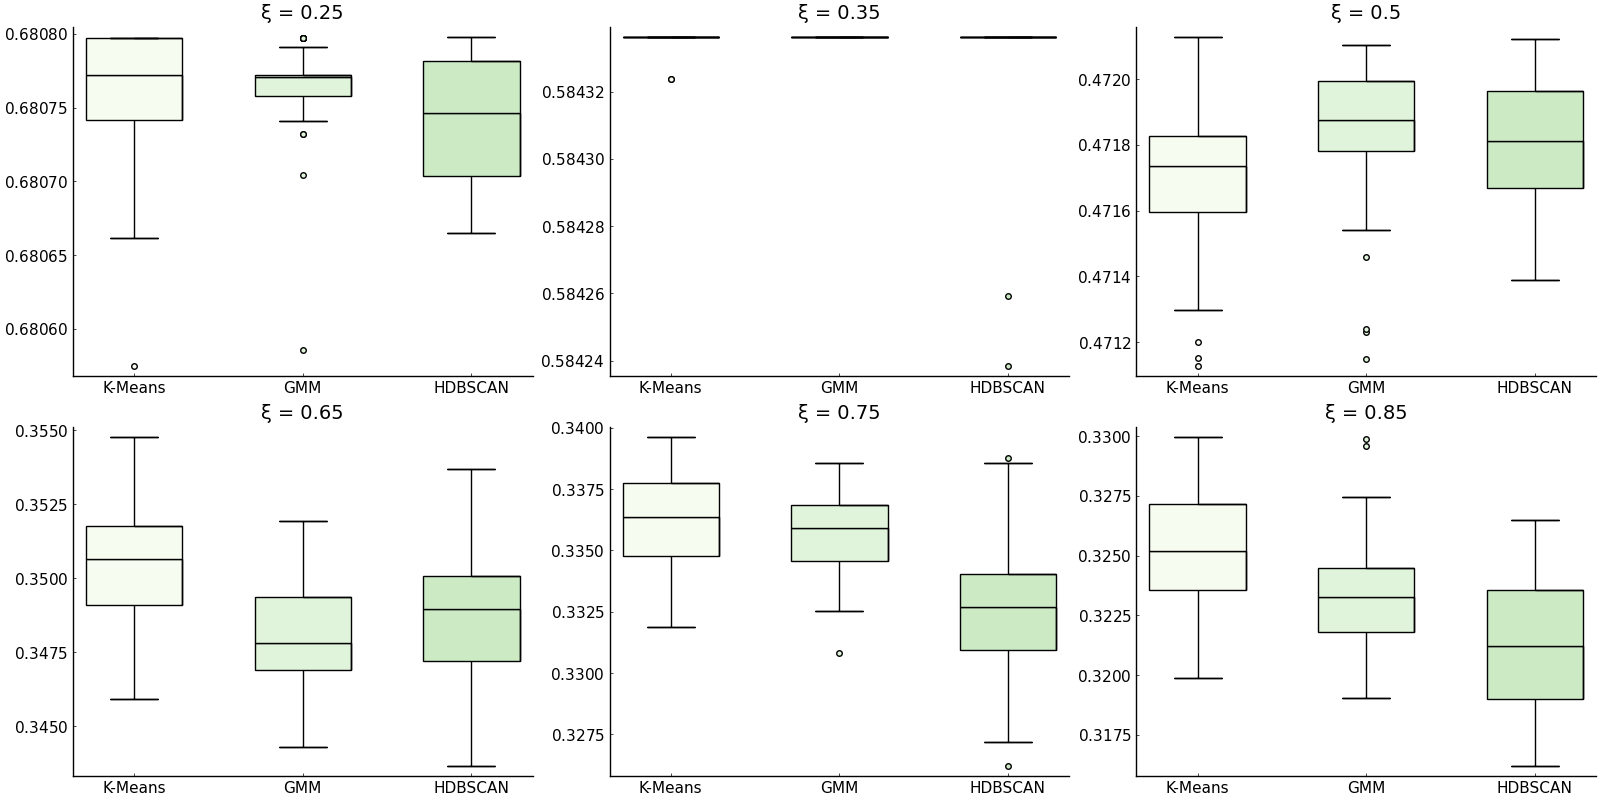

In [44]:
pllts = []
for ξ in ξs
    group = groupby(groupby(read_data("leiden", "modularity", n, ξ, β, γ, min_deg),
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :clustering_algo);
    a = [(Array{Float64}(g[g.mean .== maximum(g.mean),:][1,15:end]), unique(g[!,:clustering_algo])[1])
    for g in group][[1,3,2]] 
    data, labels = map(x->getfield.(a, x), fieldnames(eltype(a)));
    data = reduce(hcat,data)
    labelz = permutedims(String.(labels))
    p = boxplot(labelz, data,  labels = nothing,palette = :GnBu, title = "ξ = $(ξ)", 
    xtickfontsize=11, ytickfontsize=11, size = (600,500), grid=false, yformatter = :plain)
    push!(pllts,p)
end
plot(pllts..., layout = (2,3), size = (1600,800))
save_fig && savefig("scores_clustering_$(algo).eps")

**EC-Leiden** modularity for different clustering algorithms in **ABCD** graphs with different values of $\xi$ and fixed $\xi$, $\beta$, and $\delta$. For each $\xi$ and clustering algorithm embedding maximizing modularity was chosen.

In [45]:
n = 1000
ξs = [0.25, 0.35, 0.5, 0.65, 0.75, 0.85]
βs = 1.5
γs = 2.5
min_deg = 5;
algo = "leiden"
save_fig = false;

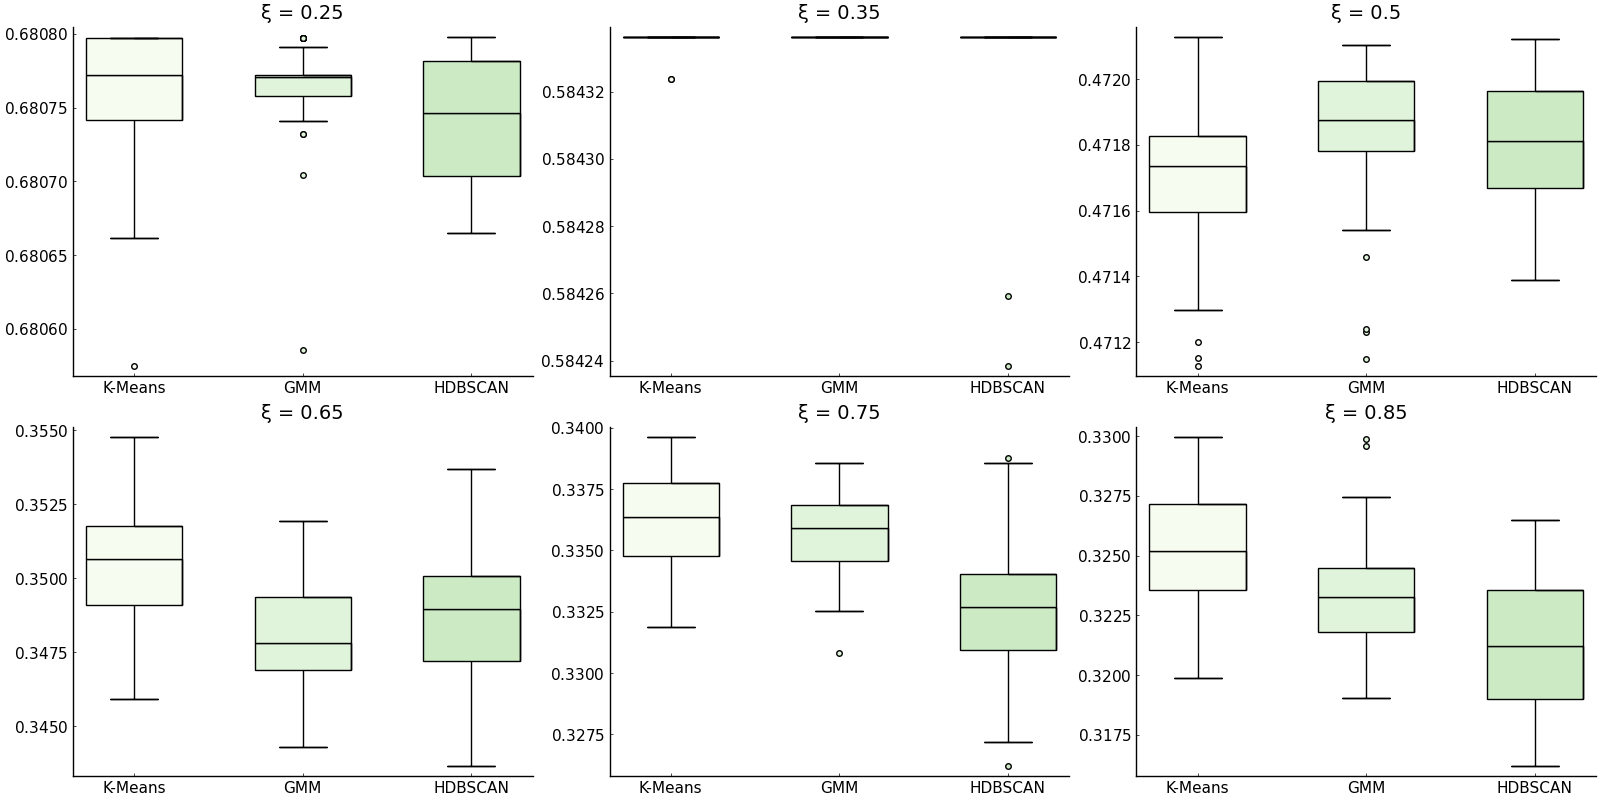

In [46]:
pllts = []
for ξ in ξs
    group = groupby(groupby(read_data("leiden", "modularity", n, ξ, β, γ, min_deg),
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :clustering_algo);
    a = [(Array{Float64}(g[g.mean .== maximum(g.mean),:][1,15:end]), unique(g[!,:clustering_algo])[1])
    for g in group][[1,3,2]] 
    data, labels = map(x->getfield.(a, x), fieldnames(eltype(a)));
    data = reduce(hcat,data)
    labelz = permutedims(String.(labels))
    p = boxplot(labelz, data,  labels = nothing, palette = :GnBu, title = "ξ = $(ξ)", 
    xtickfontsize=11, ytickfontsize=11, size = (600,500), grid=false, yformatter = :plain)
    push!(pllts,p)
end
plot(pllts..., layout = (2,3), size = (1600,800))
save_fig && savefig("scores_clustering_$(algo).eps")

Heatmap with relative modularity increase (in percentage) for various **ABCD** graphs. Each cell corresponds to **ABCD** graph with given parameters $\beta$, $\gamma$, $\xi$  and fixed $\delta = 5$. Modularity increase is represented in a color scale mapping. Each cell also records embedding (together with its dimensionality) and clustering (together with its parametrization: *number of clusters* for **$k$-Means** and **GMM**, *minimum sample size* for **HDBSCAN**.)

In [47]:
n = 1000
ξs = [0.25, 0.35, 0.5, 0.65, 0.75, 0.85]
βs = [1.1, 1.5, 1.9]
γs = [2.1, 2.5, 2.9]
min_deg = 5;
algo = "louvain"
save_fig = false;

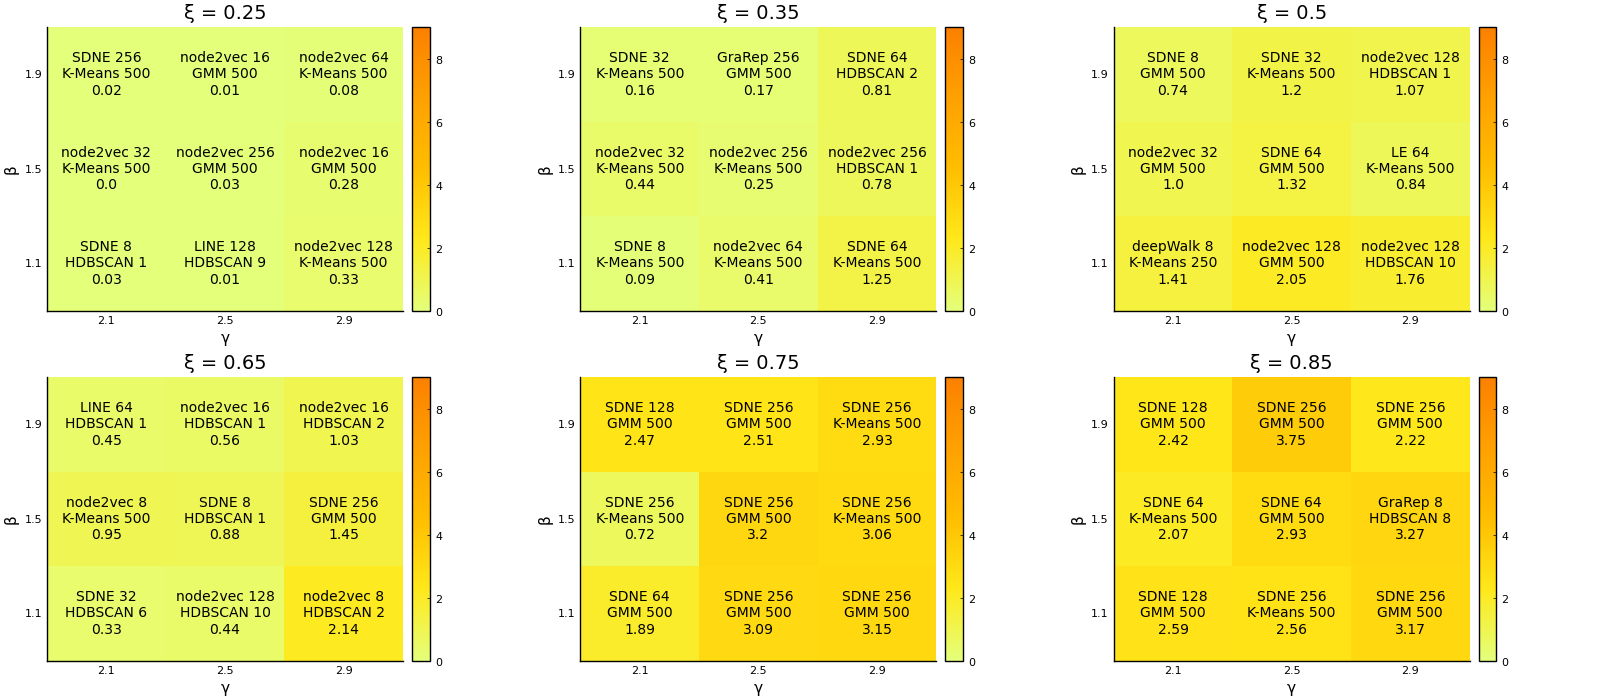

In [48]:
pllts = []
for ξ in ξs
    res = []
    for β in βs
        for γ in γs
            line = groupby(groupby(baseline_dfs["$(algo)_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
            mod = line[!,:mean][1]
            gdata = read_data(algo, "modularity", n, ξ, β, γ, min_deg)
            best_algo = gdata[gdata.mean .== maximum(gdata.mean),:]
            push!(res,[β,γ, best_algo[!,:embed][1], best_algo[!,:dim][1], (best_algo[!,:mean][1] - mod)/mod*100, 
                    std(Array(best_algo[1,15:end])), Symbol(best_algo[!,:clustering_algo][1]), 
                    Symbol(split(best_algo[!,:clustering_params][1]," ")[2])]
               )
        end
    end

    algo_table = Matrix{Symbol}(undef,length(βs), length(γs))
    dim_table = zeros(Int,length(βs), length(γs))
    mean_table = zeros(length(βs), length(γs))
    var_table = zeros(length(βs), length(γs));
    clust_table = Matrix{Symbol}(undef,length(βs), length(γs))
    clust_params_table = Matrix{Symbol}(undef,length(βs), length(γs))
    for (i,β) in enumerate(βs)
        for (j,γ) in enumerate(γs)
            line = filter(x->x[1] == β && x[2] == γ, res)[1]
            algo_table[i,j] = line[3]
            dim_table[i,j] = line[4]
            mean_table[i,j] = line[5]
            var_table[i,j] = line[6]
            clust_table[i,j] = line[7]
            clust_params_table[i,j] = line[8]
        end
    end
    t = [(j - 0.5, i - 0.5, text( "$(algo_table[i,j]) $(dim_table[i,j])\n$(clust_table[i,j]) $(clust_params_table[i,j])\n$(round(mean_table[i,j], digits = 2))" 
            ,10)) 
    for (j,i) in reshape(collect(product(1:length(γs),1:length(βs))),:)];
    p = heatmap(string.(γs), string.(βs), mean_table, c=:Wistia, xlabel = "γ", ylabel = "β", annotations= t,
        clim = (0.0, 9.02), title = "ξ = $ξ")
    push!(pllts,p)
end
plot(pllts..., layout = (2,3), size = (1600,700))
#save_fig && savefig("scores_all_$(algo).eps")

In [51]:
n = 1000
ξs = [0.25, 0.35, 0.5, 0.65, 0.75, 0.85]
βs = [1.1, 1.5, 1.9]
γs = [2.1, 2.5, 2.9]
min_deg = 5;
algo = "leiden"
save_fig = false;

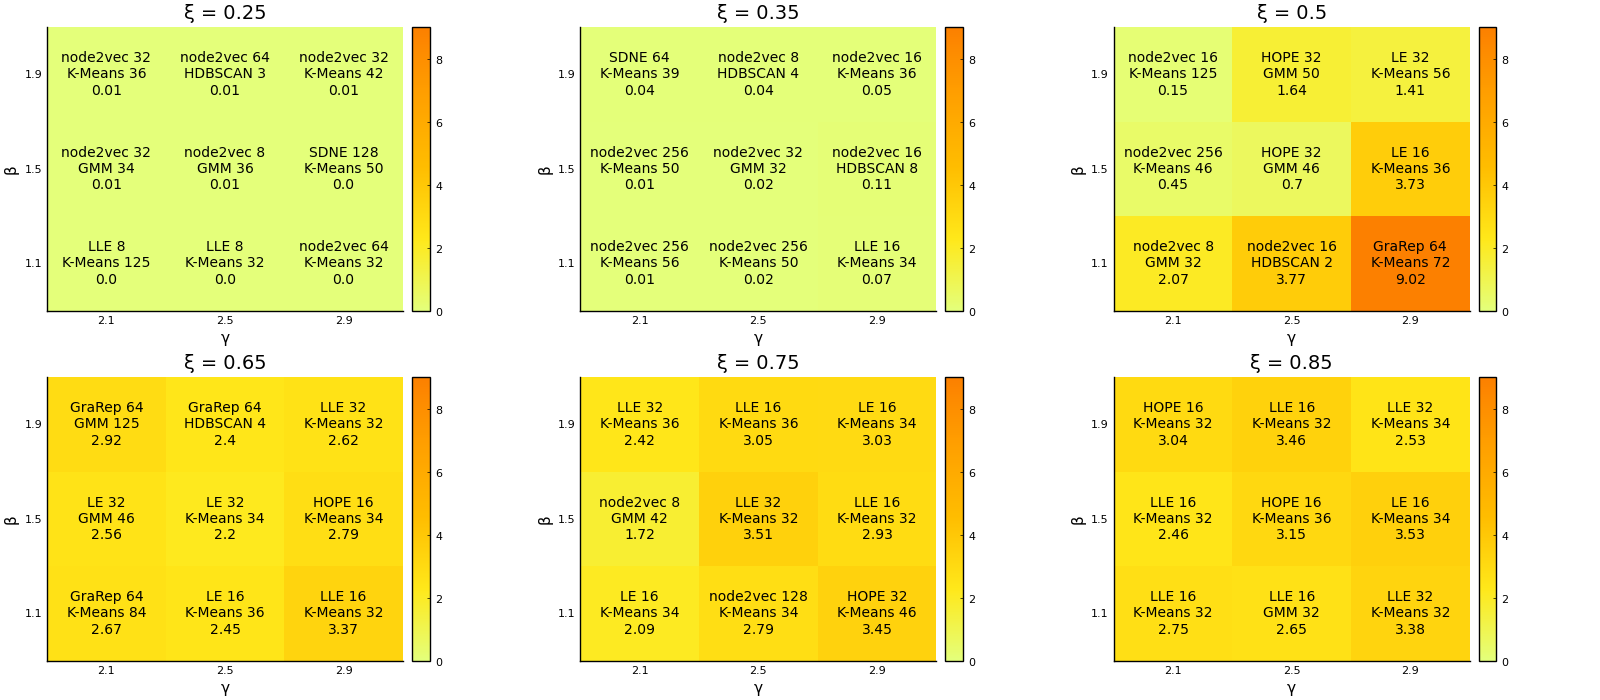

In [52]:
pllts = []
for ξ in ξs
    res = []
    for β in βs
        for γ in γs
            line = groupby(groupby(baseline_dfs["$(algo)_modularity"],
                [:n, :ξ, :β, :γ, :min_deg])[(ns, ξ, β, γ, min_deg)], :ξ)[1]
            mod = line[!,:mean][1]
            gdata = read_data(algo, "modularity", n, ξ, β, γ, min_deg)
            best_algo = gdata[gdata.mean .== maximum(gdata.mean),:]
            push!(res,[β,γ, best_algo[!,:embed][1], best_algo[!,:dim][1], (best_algo[!,:mean][1] - mod)/mod*100, 
                    std(Array(best_algo[1,15:end])), Symbol(best_algo[!,:clustering_algo][1]), 
                    Symbol(split(best_algo[!,:clustering_params][1]," ")[2])]
               )
        end
    end

    algo_table = Matrix{Symbol}(undef,length(βs), length(γs))
    dim_table = zeros(Int,length(βs), length(γs))
    mean_table = zeros(length(βs), length(γs))
    var_table = zeros(length(βs), length(γs));
    clust_table = Matrix{Symbol}(undef,length(βs), length(γs))
    clust_params_table = Matrix{Symbol}(undef,length(βs), length(γs))
    for (i,β) in enumerate(βs)
        for (j,γ) in enumerate(γs)
            line = filter(x->x[1] == β && x[2] == γ, res)[1]
            algo_table[i,j] = line[3]
            dim_table[i,j] = line[4]
            mean_table[i,j] = line[5]
            var_table[i,j] = line[6]
            clust_table[i,j] = line[7]
            clust_params_table[i,j] = line[8]
        end
    end
    t = [(j - 0.5, i - 0.5, text( "$(algo_table[i,j]) $(dim_table[i,j])\n$(clust_table[i,j]) $(clust_params_table[i,j])\n$(round(mean_table[i,j], digits = 2))" 
            ,10)) 
    for (j,i) in reshape(collect(product(1:length(γs),1:length(βs))),:)];
    p = heatmap(string.(γs), string.(βs), mean_table, c=:Wistia, xlabel = "γ", ylabel = "β", annotations= t,
        clim = (0.0, 9.02), title = "ξ = $ξ")
    push!(pllts,p)
end
plot(pllts..., layout = (2,3), size = (1600,700))
#save_fig && savefig("scores_all_$(algo).eps")

<a class="anchor" id="props"></a>
### EC Framework results relative to graph properties

---- [Return to Table of Contents](#toc) ----

In [57]:
n = 1000
ξs = [0.15, 0.25, 0.35, 0.5, 0.65, 0.75, 0.85]
βs = [1.1, 1.5, 1.9]
#βs = 1.5
γs = [2.1, 2.5, 2.9]
#γs = 2.5
min_degs = [1,2,5];

Create a data table (warning! code is slow, please run it once and then read results):

In [65]:
table = DataFrame(ξ = Float64[], β = Float64[],γ = Float64[], δ = Int[],
                   global_coeff = Float64[], avg_local_coeff = Float64[],   
                correlation_coeff =  Float64[], corr_exp = Float64[],
                avg_shortest_path = Float64[], maxpath = Float64[],
                avg_degree = Float64[], skewness = Float64[], kurtosis = Float64[], Modularity_louvain = Float64[],
                ec_louvain_modularity = Float64[], best_embed_louvain = Symbol[],
                Modularity_leiden = Float64[],  ec_leiden_modularity = Float64[], best_embed_leiden = Symbol[])

table = DataFrame(CSV.read("graph_attrs.csv", DataFrame));

Modularity increase (in percentage) from various embedding-clustering combinations as a function of global clustering coefficient . **EC-Louvain** is plotted in the left column, **EC-Leiden** in the right.

In [66]:
attribute = :global_coeff 
save_fig = false;

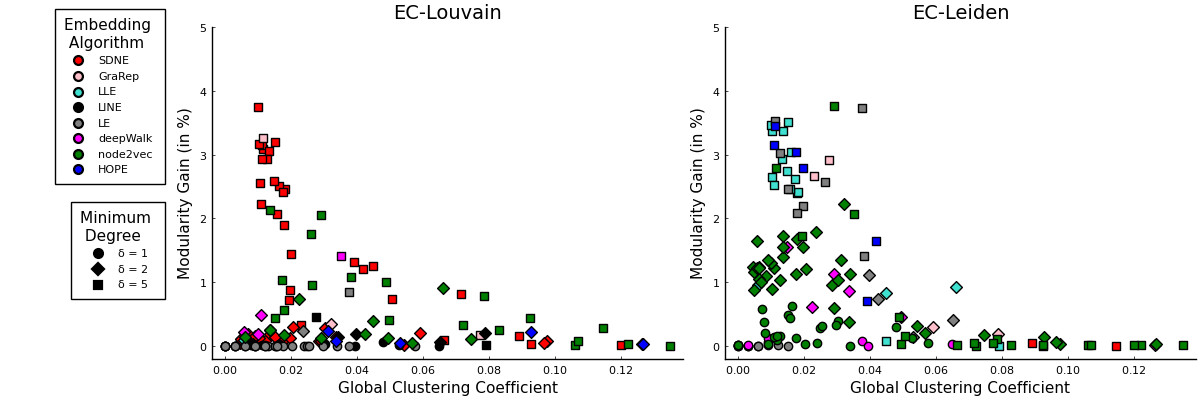

In [98]:
algos = ["louvain", "leiden"]

colors = Dict(:LE => :gray,
            :deepWalk => :magenta,
            :node2vec => :green,
            :LINE => :black,
            :SDNE => :red,
            :GraRep => :pink,
            :HOPE => :blue,
            :LLE => :turquoise);

markers = Dict(1 => :circle,
            2 => :diamond,
            5 => :square);

plot_table = table;

l1 = @layout [a; b]
l2 = @layout [a{0.15w} b c]

p1 = plot(size = (128,250),  
legendtitle = "Embedding \n Algorithm", xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for (i, embed) in enumerate(keys(colors))
        scatter!(p1, rand(1,1), markercolor = colors[embed], label = String(embed))
end

p2 = plot(legendtitle = "Minimum \n Degree",
    size = (128,250), xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for min_deg in [1,2,5]
        scatter!(p2, rand(1,1), markercolor = :black, markershape = markers[min_deg], label = "δ = $(min_deg)")
end
    
plot( p1,p2, layout = l1, size = (128, 400))
        

plots = []
for algo in algos
    plt = scatter(size = (500,500),
        legend = false,  ylim = (-0.2,10), grid = false)
    for embed in collect(keys(colors))
        plt_dt = plot_table[Symbol.(plot_table[!,"best_embed_$algo"]) .== embed, :]
        isempty(plt_dt) ||  
        scatter!(plt, plt_dt[!,attribute], 
        (plt_dt[!,Symbol("ec_$(algo)_modularity")] 
            .- plt_dt[!,Symbol("Modularity_$algo")]) ./ plt_dt[!,Symbol("Modularity_$algo")] * 100, 
        markercolor = [colors[Symbol(embed)] for embed in plt_dt[!,Symbol("best_embed_$algo")]], 
        markershape = [markers[deg] for deg in plt_dt[!,:δ]],
        markersize = 6, label = String(embed),
        ylim = (-.2,5), legend=:false, xlabel = "Global Clustering Coefficient",
        ylabel = "Modularity Gain (in %)", title = "EC-L$(algo[2:end])")
    end
    push!(plots,plt)
end

p_leg = plot(p1,p2, size = (125,400), layout = l1)
plot(p_leg,plots[1], plots[2], size = (1200,400), layout = l2)
save_fig && savefig("$(attribute)_embedding.eps")

Modularity increase (in percentage) from various embedding-clustering combinations as a function of average local clustering coefficient . **EC-Louvain** is plotted in the left column, **EC-Leiden** in the right.

In [ ]:
attribute = :avg_local_coeff 
save_fig = false;

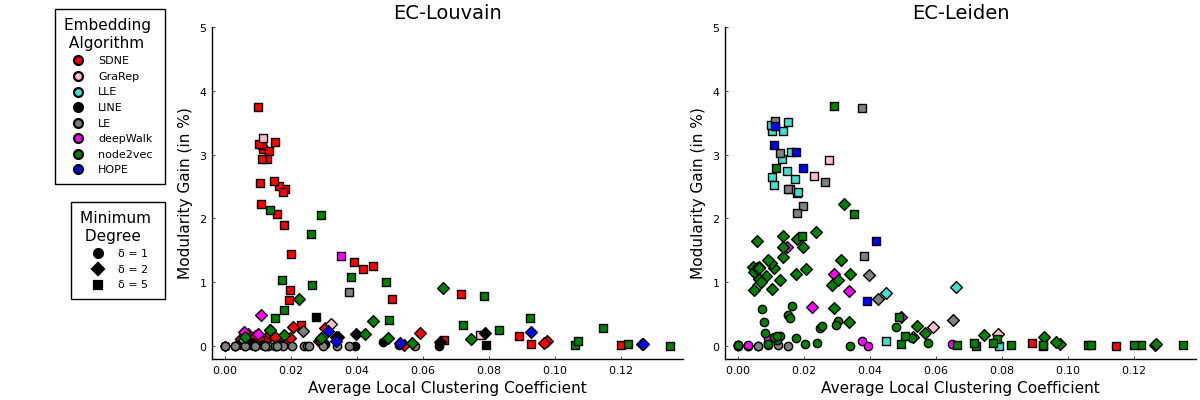

In [99]:
algos = ["louvain", "leiden"]

colors = Dict(:LE => :gray,
            :deepWalk => :magenta,
            :node2vec => :green,
            :LINE => :black,
            :SDNE => :red,
            :GraRep => :pink,
            :HOPE => :blue,
            :LLE => :turquoise);

markers = Dict(1 => :circle,
            2 => :diamond,
            5 => :square);

plot_table = table;

l1 = @layout [a; b]
l2 = @layout [a{0.15w} b c]

p1 = plot(size = (128,250),  
legendtitle = "Embedding \n Algorithm", xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for (i, embed) in enumerate(keys(colors))
        scatter!(p1, rand(1,1), markercolor = colors[embed], label = String(embed))
end

p2 = plot(legendtitle = "Minimum \n Degree",
    size = (128,250), xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for min_deg in [1,2,5]
        scatter!(p2, rand(1,1), markercolor = :black, markershape = markers[min_deg], label = "δ = $(min_deg)")
end
    
plot( p1,p2, layout = l1, size = (128, 400))
        

plots = []
for algo in algos
    plt = scatter(size = (500,500),
        legend = false,  ylim = (-0.2,10), grid = false)
    for embed in collect(keys(colors))
        plt_dt = plot_table[Symbol.(plot_table[!,"best_embed_$algo"]) .== embed, :]
        isempty(plt_dt) ||  
        scatter!(plt, plt_dt[!,attribute], 
        (plt_dt[!,Symbol("ec_$(algo)_modularity")] 
            .- plt_dt[!,Symbol("Modularity_$algo")]) ./ plt_dt[!,Symbol("Modularity_$algo")] * 100, 
        markercolor = [colors[Symbol(embed)] for embed in plt_dt[!,Symbol("best_embed_$algo")]], 
        markershape = [markers[deg] for deg in plt_dt[!,:δ]],
        markersize = 6, label = String(embed),
        ylim = (-.2,5), legend=:false, xlabel = "Average Local Clustering Coefficient",
        ylabel = "Modularity Gain (in %)", title = "EC-L$(algo[2:end])")
    end
    push!(plots,plt)
end

p_leg = plot(p1,p2, size = (125,400), layout = l1)
plot(p_leg,plots[1], plots[2], size = (1200,400), layout = l2)
save_fig && savefig("$(attribute)_embedding.eps")

Modularity increase (in percentage) from various embedding-clustering combinations as a function of correlation coefficient. **EC-Louvain** is plotted in the left column, **EC-Leiden** in the right.

In [100]:
attribute = :correlation_coeff 
save_fig = false;

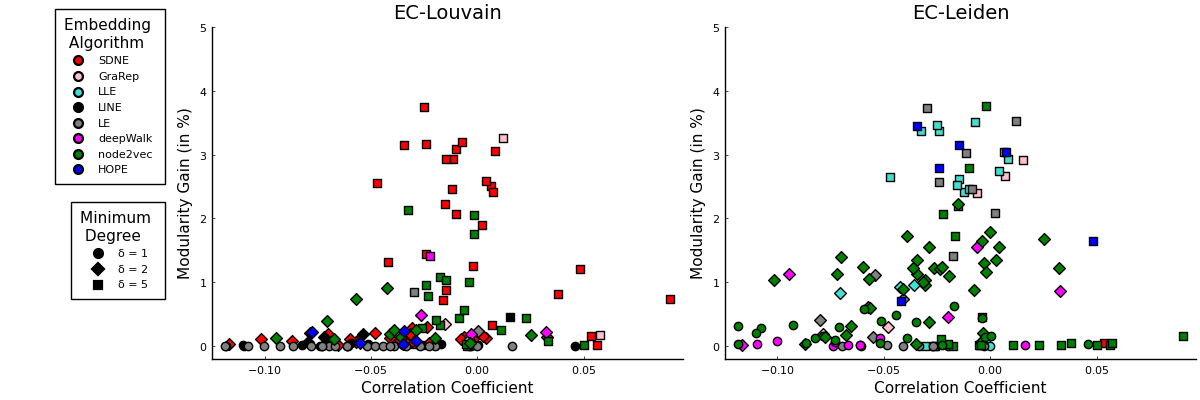

In [101]:
algos = ["louvain", "leiden"]

colors = Dict(:LE => :gray,
            :deepWalk => :magenta,
            :node2vec => :green,
            :LINE => :black,
            :SDNE => :red,
            :GraRep => :pink,
            :HOPE => :blue,
            :LLE => :turquoise);

markers = Dict(1 => :circle,
            2 => :diamond,
            5 => :square);

plot_table = table;

l1 = @layout [a; b]
l2 = @layout [a{0.15w} b c]

p1 = plot(size = (128,250),  
legendtitle = "Embedding \n Algorithm", xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for (i, embed) in enumerate(keys(colors))
        scatter!(p1, rand(1,1), markercolor = colors[embed], label = String(embed))
end

p2 = plot(legendtitle = "Minimum \n Degree",
    size = (128,250), xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for min_deg in [1,2,5]
        scatter!(p2, rand(1,1), markercolor = :black, markershape = markers[min_deg], label = "δ = $(min_deg)")
end
    
plot( p1,p2, layout = l1, size = (128, 400))
        

plots = []
for algo in algos
    plt = scatter(size = (500,500),
        legend = false,  ylim = (-0.2,10), grid = false)
    for embed in collect(keys(colors))
        plt_dt = plot_table[Symbol.(plot_table[!,"best_embed_$algo"]) .== embed, :]
        isempty(plt_dt) ||  
        scatter!(plt, plt_dt[!,attribute], 
        (plt_dt[!,Symbol("ec_$(algo)_modularity")] 
            .- plt_dt[!,Symbol("Modularity_$algo")]) ./ plt_dt[!,Symbol("Modularity_$algo")] * 100, 
        markercolor = [colors[Symbol(embed)] for embed in plt_dt[!,Symbol("best_embed_$algo")]], 
        markershape = [markers[deg] for deg in plt_dt[!,:δ]],
        markersize = 6, label = String(embed),
        ylim = (-.2,5), legend=:false, xlabel = "Correlation Coefficient",
        ylabel = "Modularity Gain (in %)", title = "EC-L$(algo[2:end])")
    end
    push!(plots,plt)
end

p_leg = plot(p1,p2, size = (125,400), layout = l1)
plot(p_leg,plots[1], plots[2], size = (1200,400), layout = l2)
save_fig && savefig("$(attribute)_embedding.eps")

Modularity increase (in percentage) from various embedding-clustering combinations as a function of correlation exponent. **EC-Louvain** is plotted in the left column, **EC-Leiden** in the right.

In [102]:
attribute = :corr_exp 
save_fig = false;

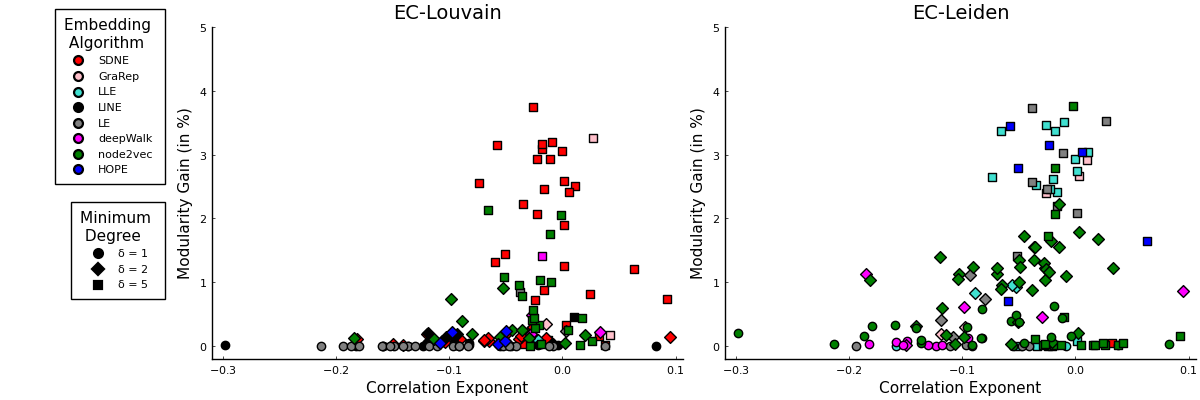

In [103]:
algos = ["louvain", "leiden"]

colors = Dict(:LE => :gray,
            :deepWalk => :magenta,
            :node2vec => :green,
            :LINE => :black,
            :SDNE => :red,
            :GraRep => :pink,
            :HOPE => :blue,
            :LLE => :turquoise);

markers = Dict(1 => :circle,
            2 => :diamond,
            5 => :square);

plot_table = table;

l1 = @layout [a; b]
l2 = @layout [a{0.15w} b c]

p1 = plot(size = (128,250),  
legendtitle = "Embedding \n Algorithm", xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for (i, embed) in enumerate(keys(colors))
        scatter!(p1, rand(1,1), markercolor = colors[embed], label = String(embed))
end

p2 = plot(legendtitle = "Minimum \n Degree",
    size = (128,250), xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for min_deg in [1,2,5]
        scatter!(p2, rand(1,1), markercolor = :black, markershape = markers[min_deg], label = "δ = $(min_deg)")
end
    
plot( p1,p2, layout = l1, size = (128, 400))
        

plots = []
for algo in algos
    plt = scatter(size = (500,500),
        legend = false,  ylim = (-0.2,10), grid = false)
    for embed in collect(keys(colors))
        plt_dt = plot_table[Symbol.(plot_table[!,"best_embed_$algo"]) .== embed, :]
        isempty(plt_dt) ||  
        scatter!(plt, plt_dt[!,attribute], 
        (plt_dt[!,Symbol("ec_$(algo)_modularity")] 
            .- plt_dt[!,Symbol("Modularity_$algo")]) ./ plt_dt[!,Symbol("Modularity_$algo")] * 100, 
        markercolor = [colors[Symbol(embed)] for embed in plt_dt[!,Symbol("best_embed_$algo")]], 
        markershape = [markers[deg] for deg in plt_dt[!,:δ]],
        markersize = 6, label = String(embed),
        ylim = (-.2,5), legend=:false, xlabel = "Correlation Exponent",
        ylabel = "Modularity Gain (in %)", title = "EC-L$(algo[2:end])")
    end
    push!(plots,plt)
end

p_leg = plot(p1,p2, size = (125,400), layout = l1)
plot(p_leg,plots[1], plots[2], size = (1200,400), layout = l2)
save_fig && savefig("$(attribute)_embedding.eps")

Modularity increase (in percentage) from various embedding-clustering combinations as a function of average shortest path. **EC-Louvain** is plotted in the left column, **EC-Leiden** in the right.

In [104]:
attribute = :avg_shortest_path 
save_fig = false;          

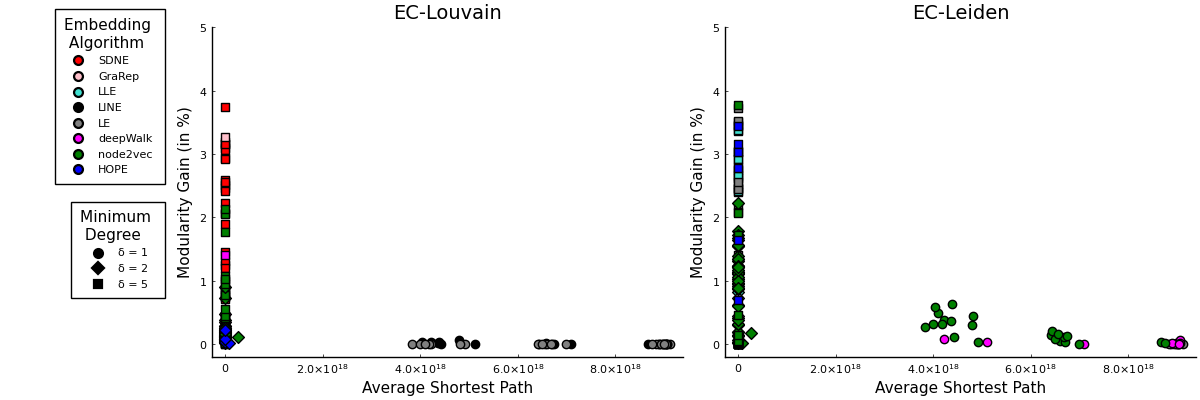

In [105]:
algos = ["louvain", "leiden"]

colors = Dict(:LE => :gray,
            :deepWalk => :magenta,
            :node2vec => :green,
            :LINE => :black,
            :SDNE => :red,
            :GraRep => :pink,
            :HOPE => :blue,
            :LLE => :turquoise);

markers = Dict(1 => :circle,
            2 => :diamond,
            5 => :square);

plot_table = table;

l1 = @layout [a; b]
l2 = @layout [a{0.15w} b c]

p1 = plot(size = (128,250),  
legendtitle = "Embedding \n Algorithm", xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for (i, embed) in enumerate(keys(colors))
        scatter!(p1, rand(1,1), markercolor = colors[embed], label = String(embed))
end

p2 = plot(legendtitle = "Minimum \n Degree",
    size = (128,250), xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for min_deg in [1,2,5]
        scatter!(p2, rand(1,1), markercolor = :black, markershape = markers[min_deg], label = "δ = $(min_deg)")
end
    
plot( p1,p2, layout = l1, size = (128, 400))
        

plots = []
for algo in algos
    plt = scatter(size = (500,500),
        legend = false,  ylim = (-0.2,10), grid = false)
    for embed in collect(keys(colors))
        plt_dt = plot_table[Symbol.(plot_table[!,"best_embed_$algo"]) .== embed, :]
        isempty(plt_dt) ||  
        scatter!(plt, plt_dt[!,attribute], 
        (plt_dt[!,Symbol("ec_$(algo)_modularity")] 
            .- plt_dt[!,Symbol("Modularity_$algo")]) ./ plt_dt[!,Symbol("Modularity_$algo")] * 100, 
        markercolor = [colors[Symbol(embed)] for embed in plt_dt[!,Symbol("best_embed_$algo")]], 
        markershape = [markers[deg] for deg in plt_dt[!,:δ]],
        markersize = 6, label = String(embed),
        ylim = (-.2,5), legend=:false, xlabel = "Average Shortest Path",
        ylabel = "Modularity Gain (in %)", title = "EC-L$(algo[2:end])")
    end
    push!(plots,plt)
end

p_leg = plot(p1,p2, size = (125,400), layout = l1)
plot(p_leg,plots[1], plots[2], size = (1200,400), layout = l2)
save_fig && savefig("$(attribute)_embedding.eps")

Modularity increase (in percentage) from various embedding-clustering combinations as a function of average degree. **EC-Louvain** is plotted in the left column, **EC-Leiden** in the right.

In [106]:
attribute = :avg_degree 
save_fig = false;

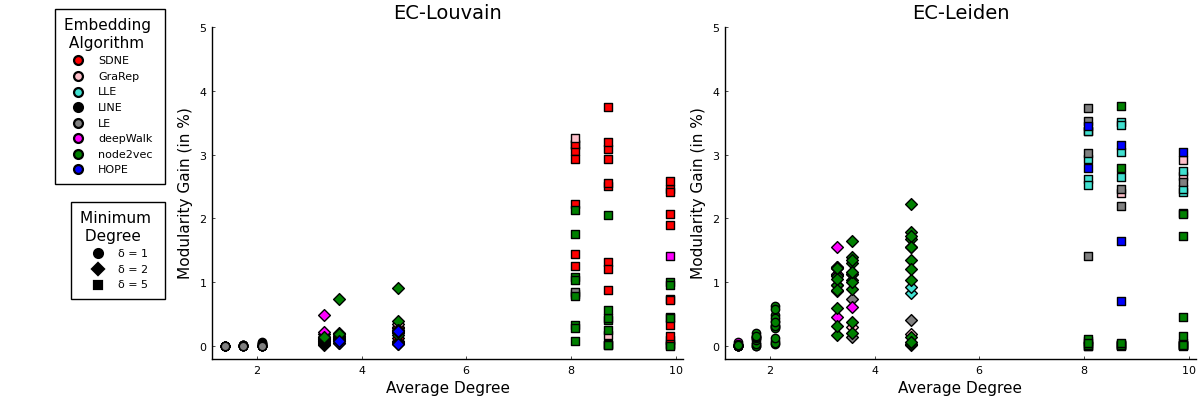

In [107]:
algos = ["louvain", "leiden"]

colors = Dict(:LE => :gray,
            :deepWalk => :magenta,
            :node2vec => :green,
            :LINE => :black,
            :SDNE => :red,
            :GraRep => :pink,
            :HOPE => :blue,
            :LLE => :turquoise);

markers = Dict(1 => :circle,
            2 => :diamond,
            5 => :square);

plot_table = table;

l1 = @layout [a; b]
l2 = @layout [a{0.15w} b c]

p1 = plot(size = (128,250),  
legendtitle = "Embedding \n Algorithm", xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for (i, embed) in enumerate(keys(colors))
        scatter!(p1, rand(1,1), markercolor = colors[embed], label = String(embed))
end

p2 = plot(legendtitle = "Minimum \n Degree",
    size = (128,250), xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for min_deg in [1,2,5]
        scatter!(p2, rand(1,1), markercolor = :black, markershape = markers[min_deg], label = "δ = $(min_deg)")
end
    
plot( p1,p2, layout = l1, size = (128, 400))
        

plots = []
for algo in algos
    plt = scatter(size = (500,500),
        legend = false,  ylim = (-0.2,10), grid = false)
    for embed in collect(keys(colors))
        plt_dt = plot_table[Symbol.(plot_table[!,"best_embed_$algo"]) .== embed, :]
        isempty(plt_dt) ||  
        scatter!(plt, plt_dt[!,attribute], 
        (plt_dt[!,Symbol("ec_$(algo)_modularity")] 
            .- plt_dt[!,Symbol("Modularity_$algo")]) ./ plt_dt[!,Symbol("Modularity_$algo")] * 100, 
        markercolor = [colors[Symbol(embed)] for embed in plt_dt[!,Symbol("best_embed_$algo")]], 
        markershape = [markers[deg] for deg in plt_dt[!,:δ]],
        markersize = 6, label = String(embed),
        ylim = (-.2,5), legend=:false, xlabel = "Average Degree",
        ylabel = "Modularity Gain (in %)", title = "EC-L$(algo[2:end])")
    end
    push!(plots,plt)
end

p_leg = plot(p1,p2, size = (125,400), layout = l1)
plot(p_leg,plots[1], plots[2], size = (1200,400), layout = l2)
save_fig && savefig("$(attribute)_embedding.eps")

Modularity increase (in percentage) from various embedding-clustering combinations as a function of skewness of degree distribution. **EC-Louvain** is plotted in the left column, **EC-Leiden** in the right.

In [108]:
attribute = :skewness 
save_fig = false;

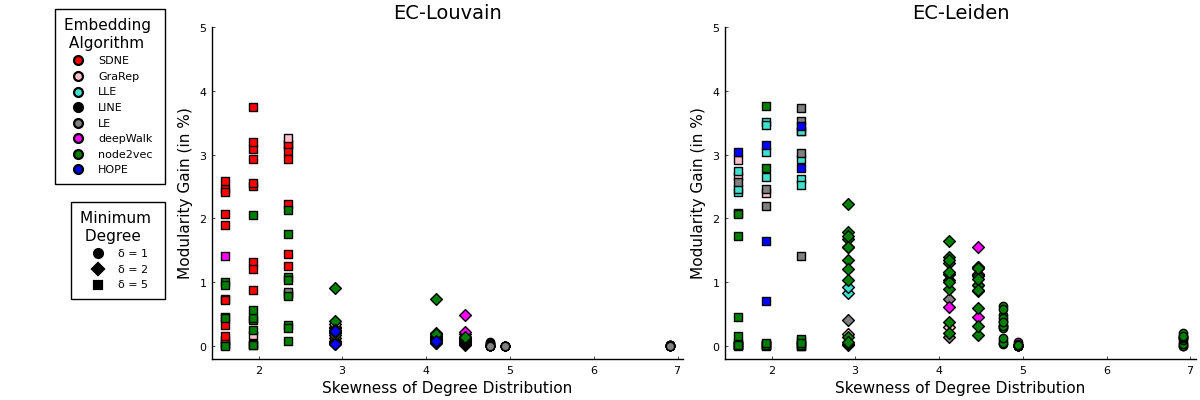

In [109]:
algos = ["louvain", "leiden"]

colors = Dict(:LE => :gray,
            :deepWalk => :magenta,
            :node2vec => :green,
            :LINE => :black,
            :SDNE => :red,
            :GraRep => :pink,
            :HOPE => :blue,
            :LLE => :turquoise);

markers = Dict(1 => :circle,
            2 => :diamond,
            5 => :square);

plot_table = table;

l1 = @layout [a; b]
l2 = @layout [a{0.15w} b c]

p1 = plot(size = (128,250),  
legendtitle = "Embedding \n Algorithm", xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for (i, embed) in enumerate(keys(colors))
        scatter!(p1, rand(1,1), markercolor = colors[embed], label = String(embed))
end

p2 = plot(legendtitle = "Minimum \n Degree",
    size = (128,250), xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for min_deg in [1,2,5]
        scatter!(p2, rand(1,1), markercolor = :black, markershape = markers[min_deg], label = "δ = $(min_deg)")
end
    
plot( p1,p2, layout = l1, size = (128, 400))
        

plots = []
for algo in algos
    plt = scatter(size = (500,500),
        legend = false,  ylim = (-0.2,10), grid = false)
    for embed in collect(keys(colors))
        plt_dt = plot_table[Symbol.(plot_table[!,"best_embed_$algo"]) .== embed, :]
        isempty(plt_dt) ||  
        scatter!(plt, plt_dt[!,attribute], 
        (plt_dt[!,Symbol("ec_$(algo)_modularity")] 
            .- plt_dt[!,Symbol("Modularity_$algo")]) ./ plt_dt[!,Symbol("Modularity_$algo")] * 100, 
        markercolor = [colors[Symbol(embed)] for embed in plt_dt[!,Symbol("best_embed_$algo")]], 
        markershape = [markers[deg] for deg in plt_dt[!,:δ]],
        markersize = 6, label = String(embed),
        ylim = (-.2,5), legend=:false, xlabel = "Skewness of Degree Distribution",
        ylabel = "Modularity Gain (in %)", title = "EC-L$(algo[2:end])")
    end
    push!(plots,plt)
end

p_leg = plot(p1,p2, size = (125,400), layout = l1)
plot(p_leg,plots[1], plots[2], size = (1200,400), layout = l2)
save_fig && savefig("$(attribute)_embedding.eps")

Modularity increase (in percentage) from various embedding-clustering combinations as a function of kurtosis of degree distribution. **EC-Louvain** is plotted in the left column, **EC-Leiden** in the right.

In [110]:
attribute = :kurtosis 
save_fig = false;

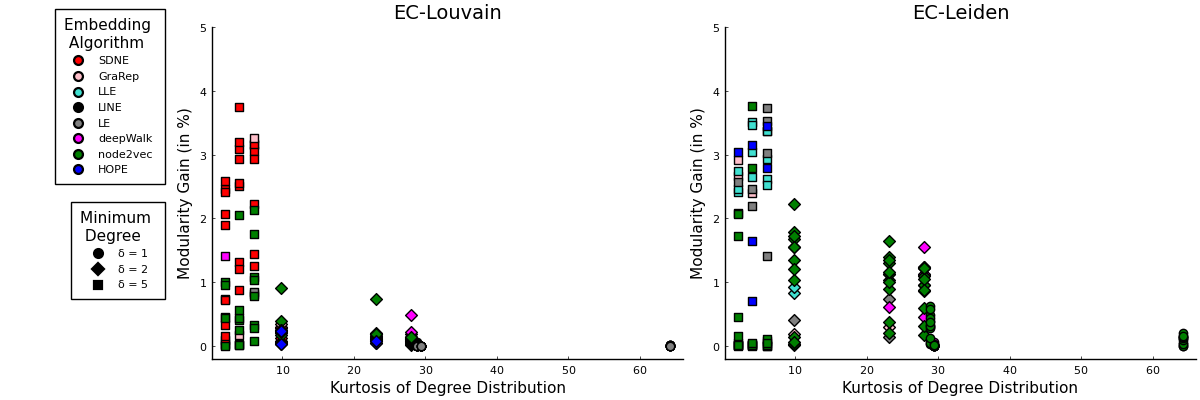

In [111]:
algos = ["louvain", "leiden"]

colors = Dict(:LE => :gray,
            :deepWalk => :magenta,
            :node2vec => :green,
            :LINE => :black,
            :SDNE => :red,
            :GraRep => :pink,
            :HOPE => :blue,
            :LLE => :turquoise);

markers = Dict(1 => :circle,
            2 => :diamond,
            5 => :square);

plot_table = table;

l1 = @layout [a; b]
l2 = @layout [a{0.15w} b c]

p1 = plot(size = (128,250),  
legendtitle = "Embedding \n Algorithm", xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for (i, embed) in enumerate(keys(colors))
        scatter!(p1, rand(1,1), markercolor = colors[embed], label = String(embed))
end

p2 = plot(legendtitle = "Minimum \n Degree",
    size = (128,250), xlim = (200,209), xaxis=false, ylim = (200,200), yaxis=false, grid=false)
for min_deg in [1,2,5]
        scatter!(p2, rand(1,1), markercolor = :black, markershape = markers[min_deg], label = "δ = $(min_deg)")
end
    
plot( p1,p2, layout = l1, size = (128, 400))
        

plots = []
for algo in algos
    plt = scatter(size = (500,500),
        legend = false,  ylim = (-0.2,10), grid = false)
    for embed in collect(keys(colors))
        plt_dt = plot_table[Symbol.(plot_table[!,"best_embed_$algo"]) .== embed, :]
        isempty(plt_dt) ||  
        scatter!(plt, plt_dt[!,attribute], 
        (plt_dt[!,Symbol("ec_$(algo)_modularity")] 
            .- plt_dt[!,Symbol("Modularity_$algo")]) ./ plt_dt[!,Symbol("Modularity_$algo")] * 100, 
        markercolor = [colors[Symbol(embed)] for embed in plt_dt[!,Symbol("best_embed_$algo")]], 
        markershape = [markers[deg] for deg in plt_dt[!,:δ]],
        markersize = 6, label = String(embed),
        ylim = (-.2,5), legend=:false, xlabel = "Kurtosis of Degree Distribution",
        ylabel = "Modularity Gain (in %)", title = "EC-L$(algo[2:end])")
    end
    push!(plots,plt)
end

p_leg = plot(p1,p2, size = (125,400), layout = l1)
plot(p_leg,plots[1], plots[2], size = (1200,400), layout = l2)
save_fig && savefig("$(attribute)_embedding.eps")

<a class="anchor" id="fb"></a>
### Facebook Datasets

---- [Return to Table of Contents](#toc) ----

In [112]:
#data directory
res_dir = "ECCD/results_real_networks/";

In [113]:
#Experiment Parameters:
min_dim = 8
no_iters = 50
measures = ["modularity"];
graphnames = [:artist, :athletes, :company, :government, :new_sites, :politician,:public_figure, :tvshow];

### Baseline Datasets

In [120]:
rough_data = Dict("louvain_modularity" => [],
                "leiden_modularity" => [],
                "ecg_modularity" => []);

In [121]:
for algo in ["louvain", "leiden", "ecg"]
    for measure in measures
        for file in readdir(res_dir)
            params = split(file,'_')
            if params[2] in ["sites", "figure"] 
                filetype = Symbol(params[1]*"_"*params[2])
                algorithm = String(params[4])
                msr = String(params[5])
            else
                filetype = Symbol(params[1])
                algorithm = String(params[3])
                msr = String(params[4])
            end
            (String(params[1]) == "results" || algorithm != algo || msr  != measure*".dat") && continue
            values = parse.(Float64,split.(readlines(res_dir * file),";")[1])
            μ = mean(values)
            σ = std(values)
            line = Any[filetype,μ,σ]
            push!(rough_data["$(algo)_$(measure)"], line)
        end
    end
end

In [122]:
colnames = [:graph,:mean,:std];
baseline_dfs = Dict("louvain_modularity" => 
    DataFrame(Matrix(permutedims(reduce(hcat,rough_data["louvain_modularity"]))), colnames),
                "leiden_modularity" => 
    DataFrame(Matrix(permutedims(reduce(hcat,rough_data["leiden_modularity"]))), colnames),
                "ecg_modularity" => 
    DataFrame(Matrix(permutedims(reduce(hcat,rough_data["ecg_modularity"]))), colnames),
    );

Modularity increase with respect to baseline (plain **Louvain**) for Facebook networks. Column*Baseline Louvain* shows the average modularity index (modularity $\times$ 100) with standard deviation. Other columns present the modularity change relative to **Louvain** (in percentage). For \textbf{EC} methods, the best performing combination of embedding and clustering algorithms was chosen.

In [124]:
save_file = false;

In [125]:
#general:
table = DataFrame(parameters = Symbol[], Louvain = Tuple{Float64,Float64}[], 
                ECG = Tuple{Float64,Float64}[], Leiden = Tuple{Float64,Float64}[], 
                EC_Louvain = Tuple{Float64,Float64}[], EC_Leiden = Tuple{Float64,Float64}[])
for graph in graphnames
    try
        mod = groupby(baseline_dfs["louvain_modularity"],
                [:graph])[(graph,)][!,:mean][1]
        lstd = groupby(baseline_dfs["louvain_modularity"],
                [:graph])[(graph,)][!,:std][1]
        louvain = round.((mod * 100,lstd*100), digits = 2)
        
 
        ecg_mod = (groupby(baseline_dfs["ecg_modularity"],
                [:graph])[(graph,)][!,:mean][1] - mod) / mod * 100 
        ecg_std = groupby(baseline_dfs["ecg_modularity"],
                [:graph])[(graph,)][!,:std][1] * 100
        ecg = round.((ecg_mod, ecg_std), digits = 2)
        
        leiden_mod = (groupby(baseline_dfs["leiden_modularity"],
                [:graph])[(graph,)][!,:mean][1] - mod) / mod * 100 
        leiden_std = groupby(baseline_dfs["leiden_modularity"],
                [:graph])[(graph,)][!,:std][1] * 100
        leiden = round.((leiden_mod, leiden_std), digits = 2)
        
        gr = Symbol(join(split(String(graph),'_')))
        ec_louvain = read_data("louvain", "modularity")
        ec_louvain = groupby(ec_louvain, [:graph])[(gr,)]
        ec_louvain = ec_louvain[ec_louvain.mean .== maximum(ec_louvain.mean),:]
        ec_louvain_mod = (ec_louvain[!,:mean][1] - mod) / mod * 100 
        ec_louvain_std = ec_louvain[!,:std][1] * 100
        ec_louvain = round.((ec_louvain_mod, ec_louvain_std), digits = 2)
        
        ec_leiden = read_data("leiden", "modularity")
        ec_leiden = groupby(ec_leiden, [:graph])[(gr,)]
        ec_leiden = ec_leiden[ec_leiden.mean .== maximum(ec_leiden.mean),:]
        ec_leiden_mod = (ec_leiden[!,:mean][1] - mod) / mod * 100 
        ec_leiden_std = ec_leiden[!,:std][1] * 100
        ec_leiden = round.((ec_leiden_mod, ec_leiden_std), digits = 2)
        push!(table, vcat(graph, louvain, ecg, leiden, ec_louvain, ec_leiden))
    catch
        push!(table, vcat(graph, fill((0,0),5)))
    end
end
if save_file
    open("xi_table_real.tex", "w") do file
                write(file, latextabular(table, latex=false))
    end
end
table

8×6 DataFrame
 Row │ parameters     Louvain        ECG            Leiden        EC_Louvain   ⋯
     │ Symbol         Tuple…         Tuple…         Tuple…        Tuple…       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ artist         (61.18, 0.52)  (0.79, 0.33)   (0.67, 0.33)  (1.03, 0.11) ⋯
   2 │ athletes       (71.08, 0.33)  (-1.88, 0.14)  (1.37, 0.09)  (0.4, 0.14)
   3 │ company        (72.83, 0.27)  (-2.39, 0.1)   (1.58, 0.08)  (0.42, 0.19)
   4 │ government     (72.74, 0.09)  (-1.56, 0.11)  (0.16, 0.06)  (0.04, 0.06)
   5 │ new_sites      (62.56, 0.21)  (-3.57, 0.13)  (1.85, 0.16)  (0.07, 0.14) ⋯
   6 │ politician     (86.82, 0.05)  (-1.4, 0.23)   (0.14, 0.04)  (0.05, 0.04)
   7 │ public_figure  (68.39, 0.11)  (-0.88, 0.07)  (0.66, 0.06)  (-0.0, 0.13)
   8 │ tvshow         (87.2, 0.08)   (-1.38, 0.11)  (0.14, 0.01)  (0.04, 0.04)
                                                                1 column omitted

Best performing **EC-Louvain** methods for Facebook datasets. Columns *Embedding Algorithm* and *Dimensions* show the best embedding algorithm and its dimensions. Columns *Clustering Algorithm* and *Parameters* show the best clustering algorithm and its parametrization (*number of clusters* for **$k$-Means** and **GMM**, *minimum sample size* for **HDBSCAN**.

In [ ]:
save_file = false;

In [127]:
#best performing algos louvain
table = DataFrame(parameters = Symbol[], Embeding = Symbol[],
                dim = Int[], embed_params = Symbol[], clustering_algo = Symbol[], clustering_params = Symbol[])
for graph in graphnames
        mod = groupby(baseline_dfs["louvain_modularity"],
                [:graph])[(graph,)][!,:mean][1]
        lstd = groupby(baseline_dfs["louvain_modularity"],
                [:graph])[(graph,)][!,:std][1]
        louvain_mod = round(mod, digits = 5)
          
        gr = Symbol(join(split(String(graph),'_')))
        ec_louvain = read_data("louvain", "modularity")
        ec_louvain = groupby(ec_louvain, [:graph])[(gr,)]
        ec_louvain = ec_louvain[ec_louvain.mean .== maximum(ec_louvain.mean),:]
        ec_louvain_mod = (ec_louvain[!,:mean][1] - mod) / mod * 100 
        ec_louvain_mod = round(ec_louvain_mod, digits = 5)
        ec_louvain_embed = Symbol(ec_louvain[!,:embed][1])
        ec_louvain_dim = ec_louvain[!,:dim][1]
        ec_louvain_embed_params = Symbol(ec_louvain[!,:embed_params][1])
        ec_louvain_clustering_algo = Symbol(ec_louvain[!,:clustering_algo][1])
        ec_louvain_embed_clustering_params = Symbol(ec_louvain[!,:clustering_params][1])
        push!(table, vcat(graph, ec_louvain_embed, ec_louvain_dim,
            ec_louvain_embed_params, ec_louvain_clustering_algo, ec_louvain_embed_clustering_params))
end
if save_file
    open("xi_best_louvain.tex", "w") do file
                write(file, latextabular(table, latex=false))
    end
end
table

8×6 DataFrame
 Row │ parameters     Embeding  dim    embed_params     clustering_algo  clust ⋯
     │ Symbol         Symbol    Int64  Symbol           Symbol           Symbo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ artist         node2vec     16  p: 4.0, q: 0.25  GMM              k: 84 ⋯
   2 │ athletes       HOPE          8  ppr              K-Means          k: 69
   3 │ company        SDNE       1024  ℓ: 2048, β: 6    HDBSCAN          min_s
   4 │ government     LINE       1024                   K-Means          k: 35
   5 │ new_sites      LLE         256                   K-Means          k: 13 ⋯
   6 │ politician     SDNE         64  ℓ: 128, β: 2     HDBSCAN          min_s
   7 │ public_figure  SDNE         64  ℓ: 128, β: 10    GMM              k: 57
   8 │ tvshow         SDNE       1024  ℓ: 2048, β: 2    HDBSCAN          min_s
                                                                1 column omitted

Best performing **EC-Leiden** methods for Facebook datasets. Columns *Embedding Algorithm* and *Dimensions* show the best embedding algorithm and its dimensions. Columns *Clustering Algorithm* and *Parameters* show the best clustering algorithm and its parametrization (*number of clusters* for **$k$-Means** and **GMM**, *minimum sample size* for **HDBSCAN**.

In [128]:
save_file = false;

In [129]:
#best performing algos leiden
table = DataFrame(parameters = Symbol[], Embeding = Symbol[],
                dim = Int[], embed_params = Symbol[], clustering_algo = Symbol[], clustering_params = Symbol[])
for graph in graphnames
        mod = groupby(baseline_dfs["leiden_modularity"],
                [:graph])[(graph,)][!,:mean][1]
        lstd = groupby(baseline_dfs["leiden_modularity"],
                [:graph])[(graph,)][!,:std][1]
        leiden_mod = round(mod, digits = 5)
        gr = Symbol(join(split(String(graph),'_')))
        ec_leiden = read_data("leiden", "modularity")
        ec_leiden = groupby(ec_leiden, [:graph])[(gr,)]
        ec_leiden = ec_leiden[ec_leiden.mean .== maximum(ec_leiden.mean),:]
        ec_leiden_mod = (ec_leiden[!,:mean][1] - mod) / mod * 100 
        ec_leiden_mod = round(ec_leiden_mod, digits = 5)
        ec_leiden_embed = Symbol(ec_leiden[!,:embed][1])
        ec_leiden_dim = ec_leiden[!,:dim][1]
        ec_leiden_embed_params = Symbol(ec_leiden[!,:embed_params][1])
        ec_leiden_clustering_algo = Symbol(ec_leiden[!,:clustering_algo][1])
        ec_leiden_embed_clustering_params = Symbol(ec_leiden[!,:clustering_params][1])
        push!(table, vcat(graph, ec_leiden_embed, ec_leiden_dim,
            ec_leiden_embed_params, ec_leiden_clustering_algo, ec_leiden_embed_clustering_params))
end
if save_file
    open("xi_best_leiden.tex", "w") do file
                write(file, latextabular(table, latex=false))
    end
end
table

8×6 DataFrame
 Row │ parameters     Embeding  dim    embed_params     clustering_algo  clust ⋯
     │ Symbol         Symbol    Int64  Symbol           Symbol           Symbo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ artist         LLE         128                   GMM              k: 39 ⋯
   2 │ athletes       LLE          16                   K-Means          k: 55
   3 │ company        node2vec      8  p: 1.0, q: 0.25  GMM              k: 44
   4 │ government     LE           32                   K-Means          k: 11
   5 │ new_sites      node2vec     32  p: 0.25, q: 1.0  GMM              k: 93 ⋯
   6 │ politician     LE           32                   K-Means          k: 93
   7 │ public_figure  LLE         128                   K-Means          k: 18
   8 │ tvshow         deepWalk   1024                   K-Means          k: 21
                                                                1 column omitted

---- [Return to Table of Contents](#toc) ----